References :
- https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf
- https://towardsdatascience.com/with-the-emergence-of-social-media-high-quality-of-structured-and-unstructured-information-shared-b16103f8bb2e
- https://pypi.org/project/tweet-preprocessor/
- https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

In [1]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
import glob

from wordcloud import WordCloud

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

read zomato and swiggy tweets from csv folder (all 45 days of tweets)

In [2]:
swiggy = pd.DataFrame()
for file_name in glob.glob("swiggy/"+'*.csv'):
    df = pd.read_csv(file_name)
    swiggy = swiggy.append(df, sort=False)
swiggy['length'] = swiggy['full_text'].apply(len)

In [3]:
zomato = pd.DataFrame()
for file_name in glob.glob("zomato/"+'*.csv'):
    df = pd.read_csv(file_name)
    zomato = zomato.append(df, sort=False)
zomato['length'] = zomato['full_text'].apply(len)

In [4]:
print(swiggy.shape)
swiggy = swiggy[~swiggy['full_text'].str.startswith("RT")]
swiggy = swiggy.drop_duplicates(subset=['full_text'], keep="first")
print(swiggy.shape)

(15551, 12)
(13154, 12)


In [5]:
swiggy.sample(100)

date  favorite_count  followers_count  friends_count  \
93   2019-07-01 18:58:05               0              194            437   
416  2019-06-27 12:09:42               0               17            253   
647  2019-06-02 11:11:42               0                2              2   
197  2019-07-03 17:19:05               0                4              7   
137  2019-06-24 16:54:49               0              349            353   
307  2019-06-23 16:17:16               0              137            479   
169  2019-06-02 17:52:16               0               51            117   
306  2019-06-25 13:57:38               0              255            177   
968  2019-06-02 06:58:05               0              605            211   
521  2019-06-02 13:32:21               0                1             45   
125  2019-06-01 18:48:06               1              168            305   
520  2019-06-12 09:16:50               1              772            291   
260  2019-06-26 16:27:08               0              101            332   
5    2019-06-29 21:43:04               0                2             23   
72   2019-06-02 19:06:13               0                4             17   
116  2019-06-19 17:59:36               1               25            172   
283  2019-06-29 17:13:04               0              543            911   
412  2019-07-10 14:57:10               1                3             21   
852  2019-06-02 08:39:42               0              278            524   
318  2019-07-02 15:08:42               0              145            146   
35   2019-06-19 19:05:11               0               45            117   
77   2019-06-15 18:49:05               0                7              9   
134  2019-06-30 18:10:46               2               59            161   
217  2019-06-16 17:24:58               0              258            353   
42   2019-06-28 20:06:18               2              284            100   
424  2019-06-13 11:59:46               0             3416           1692   
273  2019-06-27 14:21:47               0              201            803   
215  2019-06-27 15:51:44               0              138            288   
443  2019-07-03 14:46:05               0               46            280   
125  2019-07-02 17:41:19               0               36             54   
..                   ...             ...              ...            ...   
450  2019-06-23 14:30:09               0             2857           3458   
409  2019-06-26 14:33:13               0                4             63   
9    2019-06-24 21:44:33               0              403           1216   
174  2019-06-01 17:57:31               0                0              8   
318  2019-06-01 16:08:25               2              354            894   
175  2019-07-01 17:33:32               0              420            332   
525  2019-06-12 09:11:25               5              772            291   
550  2019-06-14 15:10:33               0              207            225   
555  2019-06-01 12:34:02               0              627           1062   
26   2019-06-17 20:10:14               1               86            113   
96   2019-06-12 17:59:26               0               22             31   
179  2019-06-25 16:17:48               0               10             15   
78   2019-07-02 18:18:51               0                1             28   
410  2019-06-14 16:38:35               0               57             19   
182  2019-06-29 18:22:53               0                3              0   
130  2019-07-10 18:04:56               0              378            357   
358  2019-06-24 11:24:34               0              509            248   
439  2019-06-24 09:46:29               0               38            307   
348  2019-06-26 15:15:27               0             1495           1389   
397  2019-06-28 16:26:09               0               48             79   
465  2019-06-25 08:33:25               0               47           

In [6]:
print(zomato.shape)
zomato = zomato[~zomato['full_text'].str.startswith("RT")]
zomato = zomato.drop_duplicates(subset=['date','full_text'], keep="first")
print(zomato.shape)
zomato.sample(100)

(14668, 12)
(12187, 12)


date  favorite_count  followers_count  friends_count  \
30    2019-06-16 21:09:12               4                6            114   
539   2019-07-01 10:47:07               0              106            168   
1597  2019-06-04 11:26:36               0                1              8   
623   2019-07-01 09:19:07               0               12            290   
53    2019-07-02 20:35:55               1                9             71   
702   2019-06-02 10:31:59               1                2             10   
680   2019-06-01 11:07:52               0               26            180   
497   2019-06-13 13:34:44               0               30              8   
523   2019-07-01 11:05:28               0               40            548   
179   2019-06-02 17:41:49               0               16             44   
173   2019-06-01 18:39:35               0                0             27   
373   2019-06-15 16:47:26               0               54            608   
627   2019-06-01 12:34:02               0              627           1062   
856   2019-06-03 06:34:41               0               12            125   
916   2019-06-04 15:36:00               3              133           1170   
589   2019-06-02 12:12:30               0                6            193   
414   2019-06-05 17:38:37               0               19             29   
1137  2019-06-02 01:33:14               3               14             93   
938   2019-06-02 07:04:38               0               14             29   
153   2019-07-01 17:37:33               0            11965             42   
424   2019-06-15 16:22:25               0                4             17   
158   2019-07-02 18:12:40               0               34            189   
146   2019-06-14 19:06:10               1            12024             42   
304   2019-06-20 15:56:17               0                0              2   
182   2019-06-16 18:54:47               0            12024             42   
220   2019-06-17 17:19:00               0               28             48   
251   2019-07-02 16:34:41              13            64337            916   
1678  2019-06-04 10:31:41               0            11020             41   
268   2019-06-13 16:30:49               0                9             65   
33    2019-06-02 20:44:59               0              193            710   
...                   ...             ...              ...            ...   
663   2019-07-01 08:41:52               0               17             35   
112   2019-06-25 18:41:34               0                1             57   
30    2019-06-01 21:08:56               0               10             80   
2389  2019-06-04 04:11:32               0                0            159   
434   2019-06-01 15:42:12               0               73            130   
176   2019-06-01 18:38:14               0              129            379   
271   2019-06-01 17:25:39               0               11           1042   
234   2019-06-05 18:33:43               0                0             16   
294   2019-06-16 18:12:10               0              239           2150   
437   2019-06-21 13:10:36               0                0              0   
815   2019-06-14 09:49:34               0              440            284   
559   2019-06-02 12:49:56               0               46             96   
163   2019-06-14 18:57:39               0              353            906   
155   2019-06-16 19:04:32               0            12024             42   
344   2019-07-01 15:03:05               0              104             97   
826   2019-06-03 07:19:29               0                3             51   
893   2019-06-03 05:26:24               0                6             64   
923   2019-06-01 05:39:44               0               84            134   
483   2019-06-13 13:51:54               2                1             15   
298   2019-06-02 16:42:19               0            11020             41   
186   2019-06-03 

In [7]:
zomato.to_csv('zomato_raw.csv')
swiggy.to_csv('swiggy_raw.csv')

Check lengths of swiggy and zomato text

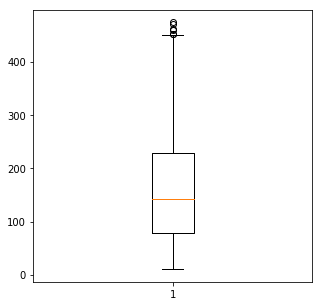

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(swiggy['length'])
plt.show()


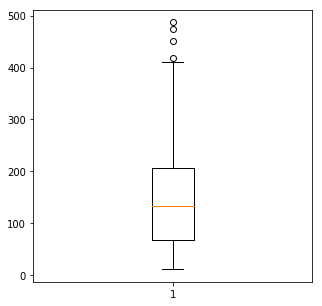

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(zomato['length'])
plt.show()

In [10]:
swiggy['full_text'].head(20)

1     @swiggy_in  I have been ordering my food since...
2        @swiggy_in @Somashekardiddi Call me 9592951991
3             @SwiggyCares Kindly refund me the amount.
4                         @swiggy_in very bad executive
5     @SwiggyCares Really sorry about the disappoint...
6               @SwiggyCares My problem is not resolved
7     @agiru_saikiran @swiggy_in @SwiggyCares @swigg...
9     @swiggy_in what the hell is this https://t.co/...
10    @swiggy_in what the hell is this... please rea...
11    Pathetic Service by @swiggy_in @SwiggyCares,  ...
12    whats great services @swiggy_in you guys cance...
13    @Trippiie_ @swiggy_in @SwiggyCares This happen...
14    @swiggy_in @SwiggyCares Its second time now th...
15    @thunderonroad @Navimumpolice @copnavimumbai @...
16    Hi @bounceshare \nIs this a perfect product pl...
17    @SwiggyCares the food description for your dis...
18    Hey @swiggy_in pls extend your services in IBS...
19    @SwiggyCares There is no response from you

<H2>Clean data</H2>

In [11]:
import preprocessor as p

stop_words = set(stopwords.words('english'))
stop_words_list = list(stop_words)

extended_list = []
with open('stop_word_extended.txt') as f:
    extended_list.extend([word for line in f for word in line.split()])

stop_words_list.extend(extended_list)
stop_words_list.extend(['humans', 'water', 'may', 'nice', 'zomato', 'swiggy', 'order', 'food'])
stop_words_list = list(set(stop_words_list))

#remove stop words
def remove_stop_words(text) :
    word_tokens = word_tokenize(text)
    filtered_tokens = [w for w in word_tokens if not w in stop_words_list]
    return ' '.join(filtered_tokens)

#clean tweets for punctuations, numbers, # etc
def clean_tweets(text) :
    print(text)
    text = BeautifulSoup(text, 'lxml').get_text()
    try:
        text = text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = text
    
    text = re.sub(r'@[A-Za-z0-9_]+','',text)  #remove all @mention
    text = re.sub('https?://[A-Za-z0-9./]+','', text)  #remove links
    text = re.sub("[^a-zA-Z\s]", "", text)  #remove all #, numbers, etc non alphabets
    text = text.lower().strip() #lowercase and strip
    text = re.sub(' +', ' ', text) #all double spaces with single
    
    text = text.replace('delivered', 'delivery')
    text = text.replace('deliver', 'delivery')
    text = text.replace('deliveryy', 'delivery')
    text = text.replace('customers', 'customer')
    text = text.replace('guys', 'guy')
    text = text.replace('boy', 'guy')
    
    text = remove_stop_words(text)
    #text = p.clean(text)
    print(text + "\n\n")
    return text

In [12]:
#print original text and clean text
swiggy['clean_text'] = swiggy['full_text'].apply(lambda x: clean_tweets(x))

@swiggy_in  I have been ordering my food since last 1 month daily, every delivery executive of yours is denying us services or delaying my every order, some of them are saying that there is ghost in my area. Is this the kind of service you provide to your "super users".??
since month daily every delivery executive denying services delaying every saying ghost area kind service super users


@swiggy_in @Somashekardiddi Call me 9592951991



@SwiggyCares Kindly refund me the amount.
refund amount


@swiggy_in very bad executive
bad executive


@SwiggyCares Really sorry about the disappointing experience you've had. Please be assured we'll have this highlighted so that such experiences can be minimized and we give you more satisfying experiences hereafter.

 ^Naveen

This was reply really excepted.
sorry disappointing experience youve assured highlighted experiences minimized satisfying experiences hereafter naveen excepted


@SwiggyCares My problem is not resolved
problem resolved


@agir

worst experience


@SwiggyCares Still waiting for a closure .
waiting closure


@SwiggyCares @swiggy_in 
I have ordered too many times still your people didn't get the address. Can't you mark and fix my location in your records.
Don't answer me just ask your tech people who are fooling you on the name of data analytics Order  44376407025
many times people address mark fix location records answer ask tech people fooling name data analytics


@SwiggyCares @swiggy_in This is too bad this is happening every time and this time it was the worst.. I can’t just order and report every time.. now I had to reorder my food from Ubereats. Ty. https://t.co/dvIzXNYjGd
bad happening every time time worst report every time reorder ubereats ty


@SwiggyCares Thanks for resolving the issue.
thanks resolving issue


@SwiggyCares Hi swiggy can you help me out with my order 44378939819.
hi


You guys are just pathetic.....unable to chew paneer and it's my drinking time...you have no idea https://t.co/JifgoD

wengers ice cream kanpur pista kulfi pc rate pista kulfi pc apps pc


@SwiggyCares My concern is that no one informed me about the cancellation... any reason why??
concern informed cancellation reason


@swiggy_in  Swiggy order #44292768789 MCDONALD'S from swiggy. Really poor packaging and food handling was also not good. Images attached for reference leakage of liquid food on over outer packaging. Kindly look into this. https://t.co/7vXj1IVReU
mcdonalds poor packaging handling good images attached reference leakage liquid outer packaging


@swiggy_in I am writing this tweet with great disappointment. I placed an order on swiggy for Domoni's pizza and they confirm the order. Later I got the call from Domino's that they can't deliver the order for security reason. Really bad reason for not giving service.
writing tweet great disappointment domonis confirm later dominos delivery security reason bad reason giving service


@swiggy_in @SwiggyCares  experiencing fake commitments and receivi

discount ke naam par bewakoof bna rhe ho kya taxes bill ka kaunsa hisab hai hai offer hand tossed additional toppings


@swiggy_in my order was canceled without any reason very upset
Your order #44124050838 has been cancelled . We have initiated a refund of Rs. 183.0 to your PayTM wallet.
canceled reason upset cancelled initiated refund paytm wallet


@swiggy_in pathetic service, placed an order 1hr b4, very rude delivery guy.
#CustomerService #swiggy #badservice
pathetic service hr b rude delivery guy customerervice badservice


@flywithsid @swiggy_in They will stick a coupon code onto you (something sub standard then the normal ongoing offers) Thats how it works :-)
stick coupon code onto something sub standard normal ongoing offers works


@swiggy_in @SwiggyCares @fooddeptgoi if the resturant is closed why it show restaurant is preparing my order!!
Very careless behaviour, Unprofessional
resturant closed show restaurant preparing careless behaviour unprofessional


@SwiggyCares @swi

true bhai becoming worst service provider rarely due worst customer support care anything neither solve issue


@SwiggyCares @swiggy_in When I complained on these issues, all I was told is a predefined well typed message "We will investigate this matter and we apologise"  I had to throw most of my orders upfront. And the worst part is you cant reach out to any higher authority.
complained issues predefined typed message investigate matter apologise throw upfront worst part reach higher authority


@swiggy_in @SwiggyCares The other day, I have recievd curd rice with hair strand in it. In one other case, I ordered Burger King food and I had the sauces spilled all over the burger. nd mind me, Burger King is where I often order and they have decent packing standards again! (4)
day recievd curd rice hair strand case burger king sauces spilled burger nd mind burger king often decent packing standards


@SwiggyCares @swiggy_in Should I assume that its been open on the way or what.. No spoon, 

found worm service becoming worst nowadays


@yshuu @ZomatoIN @zomatocare These people are the biggest thieves in the food delivery department. Seriously they cannot be trusted at all. 
@swiggy_in Is anyday better.  Infact best.  My personal experience.
people biggest thieves delivery department seriously trusted anyday better infact best personal experience


@SwiggyCares @swiggy_in  received Iddli and oottappam.with out chuttni and Saambar https://t.co/NVrJZEet5E
received iddli oottappamwith chuttni saambar


@SwiggyCares Waiting for the call
waiting


@SwiggyCares Thanks @SwiggyCares . It has been resolved by the escalation team.

@Google you have to learn how to provide service for customers from @swiggy_in 
They provide swift resolution for a mere ₹100. But for 6months you did nothing for ₹90K.
@madebygoogle @sundarpichai
thanks resolved escalation team service customer swift resolution mere months nothing k


@SwiggyCares @swiggy_in This is regarding order # 44206995169. For one 

disappointed executive professionals couldnt resolve issue time theyre denying refund delivery kind business guy run nowadays


@SwiggyCares Ordee 44202740570..as always order not delivered..you are charging restaurant charges... delivery charges for swiggy..are you not happy with the same. .
ordee always deliveryyou charging restaurant charges delivery charges swiggyare happy


@SwiggyCares Ordered via @SwiggyCares and received order with @zomatocare tape on it. Excellent! https://t.co/x2vZtkCcPH
via received tape excellent


@swiggy_in @SwiggyCares  the vegetables were stale onion was rotten the vegetables smelled very bad . Very unpleasant experience https://t.co/Raf92EMwis
vegetables stale onion rotten vegetables smelled bad unpleasant experience


@swiggy_in it’s a good way to make money by not refunding people’s money...how far will you make a fool out of your customers.???
good make money refunding peoples moneyhow far make fool customer


@swiggy_in @SwiggyCares must be the wor

called delivery guy restaurant able conversation restaurant staff due technical glitch unable view isnt contradictory wrote


@SwiggyCares Food quality - Stale food and delivery time both.
quality stale delivery time


@UberEats  you guys are seriously killing the customer service expections. You are far worst than @swiggy_in
guy seriously killing customer service expections far worst


@Chandra_gupt7 @swiggy_in @SwiggyCares don’t have a word to say to me now

They are cheat and they are not responding me in DM, on TL , in app support 😆 

Swiggy walo block kar do mujhe cause u can’t defend urself that u r not cheat 😡
word say cheat responding tl app support walo block kar mujhe cause defend urself r cheat


@He_man_t_Kumar @swiggy_in @SwiggyCares @swiggy_in @SwiggyCares don’t have a word to say to me ,

They are cheat and they are not responding me in DM, on TL , in app support 😆 

Swiggy walo block kar do mujhe cause u can’t defend urself that u r not cheat 😡
word say cheat responding

thanks


@swiggy_in Why do you say 50% off? Just say max disc 100, minimum order value 200. #StopFoolingLikeCongress
say say max disc minimum value stopfoolinglikecongress


@SwiggyCares if I don't have enough money to pay for my order, is it okay if I pay through v-bucks?
enough money pay okay pay vbucks


@SwiggyCares Details send in dm.
send


@desimojito @Zomato Use @swiggy_in instead
instead


@saptarshipr @SwiggyDaily @swiggy_in Hey, love the app. What software did you guys use to prototype this?
love app software guy prototype


@desimojito @Zomato Sir zomato indirectly bole raha ki bhai 200 se par Kar order karo😂, try @swiggy_in
sir indirectly bole raha ki bhai se par kar karo try


@swiggy_in @SwiggyCares really??Chicken, mutton, fish are new veg. https://t.co/i9Kh004J2q
reallychicken mutton fish veg


@desimojito @Zomato Hadn't you heard of @swiggy_in yet??🙄
hadnt heard


@SwiggyCares @NehaGore17 I know DM ing guys will be experienced and privileged. But why advertise if no o

sure happened anyone else second time happening portions beef chappathi alibaba dishes via


@SwiggyCares Yes. Got a call from someone polite and helpful. 
It would be splendid service, had only it been taken care of sooner, instead of over an hour and multiple tweets.
yes someone polite helpful splendid service taken care sooner instead multiple tweets


032 #CrowdWisdom You will never feel its presence but you'll feel its absence. That’s good design: @saptarshipr Design @swiggy_in #ProductDesign #DesignThinking | shared by Felix Lee
crowdwisdom never feel presence youll feel absence good design design productdesign designthinking shared felix lee


@SwiggyCares I want my money back.
I can't even call as my number is switched off.
Why can't u guys help ur customers.
Super members also suffer so much...
money switched guy customer super members suffer


@SwiggyCares Your customer service executive said its not in his hand to provide replacement or refund.
I mean why have u kept people 

many


@SwiggyCares   i am still waiting for the response. Kindly give an update https://t.co/UWCDTX0DvV
waiting response update


What an Amazing Delivery @swiggy_in , you made it in just 17 mins which @UberEats took 1:45 hr and then cancelled it.👏👏👏 https://t.co/Gbi81D9BXr
amazing delivery made mins took hr cancelled


@SwiggyCares worst CS from swiggy.I have been charged twice for the order #42740820472 but I got the refund only once did shared the screen shots too with CS team but till today the issue is not resolved. Need to explain the same issue each and every time to a new CS executive😡
worst cs swiggyi charged twice refund shared screen shots cs team till issue resolved explain issue every time cs executive


@SwiggyCares Already complained with the customer care. Recieved scripted replies and no solution. Order number #44457238321.
already complained customer care recieved scripted replies solution


@swiggy_in I love SWIGGY &amp; miss it ☺☺
love miss


Recieved the spilled f

plastic straws option exclude drinks option make straws optional cut plastic


@swiggy_in what a joke. Never revived my order 44982966970 even after talking to swiggy support for 2 hrs. wasted my energy...very pathetic service.. :(
joke never revived talking support hrs wasted energyvery pathetic service


@Abhinav48353093 @SwiggyCares @swiggy_in He already shared you can check snap shot and see the quality n quantity of order https://t.co/2SE557FY6A
already shared snap shot quality quantity


@SwiggyCares Ohhh you feel so sorry #Swiggy I already gave my order no in my message for your info. Should be ashamed of shit service you are giving
ohhh feel sorry already gave message info ashamed shit service giving


Swiggy fucked up my order again, it says it has delivered but no one received it in my house.
And now the restaurant is unreachable
@swiggy_in @SwiggyCares
fucked says delivery received house restaurant unreachable


@SwiggyCares Does it really matter, it took him 1:30 hours to d

thanks quick response good response twitter


@SwiggyCares Quality of the food was very bad,no salt and roti was also very tight,very bad service by swiggy,worst service. Request all how see this never from swiggy... https://t.co/ADYSj9FTZ9
quality badno salt roti tightvery bad service swiggyworst service request never


Hey @SwiggyCares I have checked. With the restaurant, they said it's the same for dine in and take away...in fact they said they can do the delivery themselves next time in the given price..and the extra amount hv been pocketed by Swiggy ...am i missing something here? Shocking https://t.co/KUI5HkeZSw
restaurant dine awayin fact delivery next time given priceand extra amount hv pocketed missing something shocking


@srajmali @swiggy_in Hey Suresh! We are sorry for the ordeal you had to endure with us. It was never our intention to make your time unpleasant. Please do meet us in DM and help us with the order details so we can look into this and turn this around.
https:/

kaha kaha bachat karenge ab p ab aur nahi


@PhlegmaticCat @swiggy_in Swiggy and Zomato bhool jaao. Apna khana khud banao. Bimaari se duur aur Paise ki bachat
bhool jaao apna khana khud banao bimaari se duur aur paise ki bachat


@SwiggyCares So that you can say that time has passed and I can't help with old issues?? #DontSwiggyIt https://t.co/15UwPOFkO4
say time passed old issues dontswiggyit


@SwiggyCares You have charged Rs.10. recently when I purchased by walk in it was Rs 4. No change in the packing. Why are you charging additional on packing? https://t.co/NDKOF1w9zn
charged recently purchased walk change packing charging additional packing


@ItikaSPunit gender specification should be banned. seriously. and @swiggy_in shud use their data wisely!
gender specification banned seriously shud data wisely


@ZomatoIN @zomatocare 
# order id 1152086380
no response from chat support and no processing of order
#hellexperience
#worstapp
#worstplatform
i think should use @swiggy_in always 

delivery pathetic delivery disappointed


@SwiggyCares This is a different issue and that was different. I didn't get my refund yet for the previous order and this time around I scheduled delivery time
different issue different refund previous time around scheduled delivery time


@swiggy_in really disappointed with your customer support services. I ordered 1 burger but got charged for two. When approached your customer care no response either by staff or on email as assured. Is this a deliberate delay? Or some kind of connivance?? Highly unethical. https://t.co/ueEAoFpQVf
disappointed customer support services burger charged two approached customer care response either staff email assured deliberate delay kind connivance highly unethical


@SwiggyCares I have received melted ice cream which is of no use to me. Order id- 44639231582. Customer care is saying they cannot do anything.  Can you please let me know what should I do of losing my hard earned money
received melted ice cream cus


@SwiggyCares Atleast reply when you ask a customer to DM you! @SwiggyCares @swiggy_in
atleast ask customer


And its not even about refund anymore. It's just about speaking against their terrible customer service, and how when companys like @swiggy_in get big enough, they can openly afford to annoy their customers!! #SwiggySucks
refund anymore speaking terrible customer service companys big enough openly afford annoy customer swiggysucks


@SwiggyCares Apparently @swiggy_in has guidelines on how to deceive customers!.. Coz if a wrong item delivered is not eligible for refund / replacement, I don't know what else would be!!

Ps: I asked for exact guildlines and the executive shyed away 🤷‍♂️ https://t.co/nTb83YLvwm
apparently guidelines deceive customer coz wrong item delivery eligible refund replacement else ps asked exact guildlines executive shyed


Hungry? @swiggy_in  will make sure you remain hungry. When delivery boy is stuck due to some reason, it is the customer who pats the pri

swear stop using day super expires


@whatifidothis @SwiggyCares Thdey are getting worse by each passing day. executives are rowdy and untrained.
thdey worse passing day executives rowdy untrained


@Jagan_FMB @saikris47047996 @swiggy_in https://t.co/70qOkuc0im



@Nirmalogy @SwiggyCares you shud be angry coz swiggy be useless. yesteray they took 1.5 hours to deliver poha from a restaurant thats on my street. the app showd that the delivery guy went 15 kms away from our location with the food for sm reason and also he will be there in 2 mts. Teleport much! 😡
shud angry coz useless yesteray took delivery poha restaurant street app showd delivery guy went kms location sm reason mts teleport


@SwiggyCares Thankyou for showing your concern and solving the problem over call.
thankyou showing concern solving problem


@SwiggyCares That is what I was trying to explain @swiggy_in @SwiggyCares that I was promised something on phone and that did not happen.
trying explain promised something pho

havent received bt message delivery


@SwiggyCares  what an experience 😁 such pathetic chat wow i mean now while talking to you guys we will leave all our other tasks so that for one small help we can give you atleast an hour 🤣 @swiggy_in https://t.co/m52udBa0gY
experience pathetic wow mean talking guy leave tasks small atleast


@SwiggyCares @Ammy12 Yes... That's how their customer service works... They instead blame customers and cite helplessness in dealing with restaurants
yes customer service works instead blame customer cite helplessness dealing restaurants


@SwiggyCares sir your service is great
sir service great


@SwiggyCares You need to fix your systems, and that would not require a phone call please.. Had enough!
fix systems require phone enough


@SwiggyCares Still no call, your delivery executives are ending the chat. Not even listening to me
delivery executives ending listening


@SwiggyCares team is this Roti. Ordered roti they gave tandoor Roti https://t.co/ppSOsu8yhr


never money stuck youre ready refund kind customer service regular customer


@SwiggyCares Cheated by Swiggy! Ice cream delivered is half empty in 2 cups and no seal given. #Sundayfraud Is this how u deliver orders? https://t.co/3uAPJwq93n
cheated ice cream delivery half empty cups seal given sundayfraud delivery


@SwiggyCares se the bulshit reply from chat team https://t.co/1tXRkpydzY
se bulshit team


@SwiggyCares @swiggy_in  don't order for lunch during lunch, try order during breakfast for lunch or dinner 🙏
lunch lunch try breakfast lunch dinner


Please be sure that this happens when you get a stale and third class food and complain over chat.
They will take money @SwiggyCares @swiggy_in and send stale and poor food and after will tell you we can only take feedback https://t.co/69xUr4yr4B
sure happens stale third class complain money send stale poor tell feedback


@SwiggyCares Thanks got the refund
thanks refund


@SwiggyCares hi Shruti don't need ur appology . Need to deliver m

received bad quality value compensation usual useless compared shut company


@swiggy_in
I didn't receive my order and status changed to your order delivered.
And received no proper help from your customer support.
receive status changed delivery received proper customer support


@swiggy_in @SwiggyCares 

I am an old Swiggy Customer.
But I am highly dissatisfied with
SWIGGY concerning my order
no.43778652226 of last evening.

Can I expect a call from someone
responsible from SWIGGY on my
Mobile no.9831041414...❓❓❓
old customer highly dissatisfied concerning evening expect someone responsible mobile


@SwiggyCares After messing up on your order... There's no body to complain to.  The chat helpline took 40 min to respond
messing theres body complain helpline took min respond


@Ibleed_sarcasm @yaddymania @SwiggyCares @SwiggyCares   such a irony
irony


@SwiggyCares I didn't recieve my order. Got message that food delivered. When I report no response.
recieve message delivery report resp

mari ala adigite em chepali


I love this ad.. @swiggy_in 🤣🤣🤣🤣 https://t.co/MsJsfYVP25
love ad


@SwiggyCares Food not delivered, but got a message saying order delivered. the delivery executive is not picking up the phone. no response in the chat as well. sent you a DM with details please help.
delivery message saying delivery delivery executive picking phone response sent


@swiggy_in hello swiggy I ordered around 8.15 pm and still it's not delivered . I am trying to reach through chat and call but no luck. https://t.co/4LlwUlUv60
hello around delivery trying reach luck


@Coolest_Vinay @swiggy_in Mekkesava
mekkesava


@GuptaWords @swiggy_in 😂😂😂😂 Uber eats fast ga vachidhi
uber eats fast ga vachidhi


@swiggy_in @aajtakHD @IndiaToday very pathetic service given swiggy delivery executive damaged my parcel on the way but informed me when I called to swiggy team then after long wait they cancelled my order without any intimation
pathetic service given delivery executive damaged parcel i

renewed super guess recieved incorrect think opt super keep trusting guy keep messing always let


@SwiggyCares You guys dont deserve it. Uninstalled! @UberEats it is. Fuck off
guy deserve uninstalled fuck


Thanks @swiggy_in @SwiggyCares for the refunding my money. I expect that next time your customer care executives will understand the problem and refund money instead of coupons. https://t.co/gNhbq84H4U
thanks refunding money expect next time customer care executives problem refund money instead coupons


@SwiggyCares Thank you for your understanding. I appreciate your prompt &amp; kind response.
thank understanding appreciate prompt kind response


Items were missing from my meal and no compensation done by swiggy.... Is your customer responsible for your mistakes... @SwiggyCares @swiggy_in https://t.co/GIg6xieUXI
items missing meal compensation done customer responsible mistakes


@SwiggyCares Thank you for showing your concern and reversing the wrongly charged cancellation fee.
t

delivery time canceled cause estimated delivery time plus wasnt confirmed resaturant kiddin


@SwiggyCares : In guntur if we order from swiggy, For delivery executive assignment it is taking too much time. Do we need to stay hungry ?? So the name Hunger saviour will not apply. Yesterday also I faced the same issue and cancelled the order. But they charged for cancellation
guntur delivery executive assignment time stay hungry name hunger saviour apply yesterday faced issue cancelled charged cancellation


@SwiggyCares @harshamjty As customer want simple answer - who does what by when ... https://t.co/tVDUm9mEIH
customer simple answer


@swiggy_in  if you cabt deliver branded order please do not show the option in your app..totally disappointed..
cabt delivery branded show option apptotally disappointed


@swiggy_in and @PhonePe_ have got some extremely smart and funny ads during the #CWC19
extremely smart funny ads cwc


@SwiggyCares So you  can't deliver the order details to restaurant

hi daily plan active lost phone impossible delivery executive contact possible cancel plan alternate urgent


@SwiggyCares Send him my thanks 😊
send thanks


I got a wromg order, agents said i will be getting a refund but did not after 2days! Now all agents are running away saying they xannot do anything! Never order from swiggy! Thieves! @swiggy_in @swiggyindia @SwiggyCares #swiggy #thief #onlinefood #ecom #Mumbai
wromg agents refund agents running saying xannot anything never thieves thief onlinefood ecom mumbai


@tushar009700 @SwiggyCares Thnk u so much broman♥️
thnk broman


@WeAreRanchi @swiggy_in @SwiggyCares Swiggy or piggy?
piggy


@SwiggyCares @WeAreRanchi Swiggy or piggy?
piggy


@swiggy_in why to run a business if you cannot ensure a good quality and quantity.
run business ensure good quality quantity


@dhuppi_harika @swiggy_in Pls check DM



Happy birthday our dear friend. We all hope that your special day is full of fun and happiness. We are always with you in any situa

deliverys luxurious thali nonfoodgrade poly bags complaint govt authorities play customer health


@SwiggyCares @swiggy_in https://t.co/9QMMkoo44B



@theesmaarkhan @swiggy_in @UberEats @Zomato 40 above is way too much ,sometimes they charge more than 60
sometimes charge


@SwiggyCares Replied with details
replied


@swiggy_in @SwiggyCares  order-43688136529. After making me wait for half an hour , delivery agent is saying he won't deliver this order? I had also contacted swiggy and delivery agent after placing the order. They said they will deliver the order. Now rejecting?
making wait half delivery agent saying wont delivery contacted delivery agent placing delivery rejecting


@SwiggyCares @theesmaarkhan So u guys compel us to go for SUPER ,why ?
guy compel go super


@swiggy_in @SwiggyCares
Abruptly ending convo ✔️
Didnt address the thing i wanted ✔️
Issue not resolved ✔️

This is how it is everytime with your customer care. I'm done.
Check comments for further screenshots. https:/

think swigg foodpanda better


@SwiggyCares @harshamjty @nandanreddy I don't want chit-chat with u in DM, I want an official reply from @HoiFoods, why this happened &amp; where your sense of ownership gone at the time of packing?
chitchat official happened sense ownership gone time packing


@swiggy_in @SwiggyCares Order no 42479695508 i have ordered 3 plate faluda kulfi but i recd only 2 plate oe plate is missing. Its really humiliating as today is my daughters birthday and have some guest at home.

Really disappointed ☹️
plate faluda kulfi recd plate oe plate missing humiliating daughters birthday guest home disappointed


@pronitr @SwiggyCares I think there should be proper compromise so that all of them return delighted. In this hot summer there's should be some proper initiatives so that they remain well and serve us day and night the way they are doing till date.
think proper compromise return delighted hot summer theres proper initiatives remain serve day night till date


@swig

issue related coupen code payment complaining since afternoon executives nit able resolve treat customer


@swiggy_in @swiggy_in @SwiggyCares @WeAreSwiggy



Hi sir from next month i. e in July we heard some rumours that the order amount is going to be reduced to 28 rupees per order. Kindly pass a statement regarding this @harshamjty @swiggy_in
hi sir next month e july heard rumours amount going reduced rupees per pass statement regarding


@swiggy_in  Cancelled my ORDER #42456790277 without trying to call me on my number,even delivery guy confirmed same...on calling CC...they  r saying feed Guests with apologies we delivered ...Great service
cancelled trying numbereven delivery guy confirmed sameon calling ccthey r saying feed guests apologies delivery great service


I am a super member of @swiggy_in and I just realized they have started delivering in my area (some 30 kms away from main Jaipur city/my office). A boy says thank you 🙏
super member realized started deliverying area kms 

dear feel junk killing people substance think limit delivery unhealthy foods customer using intelligence data consumption pattern


This is not acceptable waiting for order more than 1.5. Hours and the customer care calls and tell me restaurant is not giving order and the customer care guy cut the call when I asked for explanation.. this is worst customer care service @swiggy_in
acceptable waiting customer care calls tell restaurant giving customer care guy cut asked explanation worst customer care service


@OYERJALOK @swiggy_in @SwiggyCares Cheaters they are
cheaters


@NotRaichand @swiggy_in @SwiggyCares @WeAreSwiggy Stop picking food from garbage bins
stop picking garbage bins


@swiggy_in @SwiggyCares @Zomato @UberEats  wtf has just happened to swiggy customer support. are you guys really making much profit , right ? because ur customer sevice is sucks hard with every passing day https://t.co/TKcfzuBgdw
wtf happened customer support guy making profit customer sevice sucks hard eve


@Aarripattiaryan @prasannacri @bharatnj2 @pandumint @PandiyanDr @Ulavappa10 @BCCI @swiggy_in In chennai only started waving flags of saffron will start waving soon
chennai started waving flags saffron start waving soon


@SwiggyCares @swiggy_in #swiggy #swiggycheats #swiggycheatsagain it's been more than month, received call after every tweets but still not refunded! Everytime in dm u ask order details, u retard? 
Paisa waps de bhai tere calls ka kya aachar daalu? #pathetic #boycottswiggy https://t.co/yG7S5fBdfs
swiggycheats swiggycheatsagain month received every tweets refunded everytime ask retard paisa waps de bhai tere calls ka kya aachar daalu pathetic guycottswiggy


@SwiggyCares Your guy called Adarsh just called me, and I am ok with the resolution.
guy called adarsh called ok resolution


#SCAM when @dominos can not deliver within 30min and @swiggy_in  supports them https://t.co/FGLbMKF8AT
scam delivery within min supports


@Ambadan24 @Zomato @swiggy_in @UberEats Worst custom

response wasted mins customer owned waiting


@SwiggyCares Madam it has not been resolved. Ask your personnel who has spoken with me over the call!
madam resolved ask personnel spoken


@Narrativebuild1 @BCCI @swiggy_in It's not rain there dude its heavenly cow piss... Stop ur blasphemy...
rain dude heavenly cow piss stop blasphemy


@Narrativebuild1 @PandiyanDr @BCCI @swiggy_in Why ya? How did you do this. https://t.co/jmpfgAeUyy
ya


@swiggy_in @SwiggyCares..can u please look into this..



@SwiggyCares Since you have a saffron logo , are you ideologically aligned with the BJP🤗
I am bored and want something to outrage over
since saffron logo ideologically aligned bjp bored something outrage


@SwiggyCares @swiggy_in @SwiggyCares



@SwiggyCares Worst service. You should shut shop
worst service shut shop


@SwiggyCares I ordered food from nearby place 65 minutes ago and still waiting for delivery executive to be assigned. Pathetic service by swiggy
nearby place ago waiting delivery ex

added careless restaurant service


@SwiggyCares You here to loot people's money or what ?? In dms also you talking indirectly am I gonna get my refund or not
loot peoples money dms talking indirectly gon na refund


@SwiggyCares I checked with restaurant . They didn't send order to their kitchen still. Very very disappointed.
restaurant send kitchen disappointed


@SwiggyCares can anyone eat this, not even a beggar can eat it. Such a stale and worst food I've ever seen in my life. And the pathetic part is they delayed in responding me and they closed chart as m not responding. https://t.co/8A1kvAbYwR
anyone eat beggar eat stale worst ive ever seen life pathetic part delayed responding closed chart responding


@SwiggyCares Yeah! Shahrukh Khan came with the speed of https://t.co/no3kDq5hu4 and delivered the order which is now inside me !
yeah shahrukh khan came speed delivery inside


@bishalaec @swiggy_in @SwiggyCares Try zomato
try


@swiggy_in see how the order was delivered, missin

heyy restaurants reducing drastically nallagandla area hyderabad sure show though specific reason forcing whose customer service bad


@kingfisherontap @swiggy_in Hi Urvashi, we're so sorry about this. Kindly share your contact details on DM so we can get in touch with you.
hi urvashi sorry contact touch


@AniruddhasT @swiggy_in please answer him 😐
answer


Ordered food for the first time from @foodmandu !! Reminds me of the first time i used @swiggy_in in Bangalore. Startups in Kathmandu seem to be doing great :)
first time reminds first time used bangalore startups kathmandu seem great


Dear @swiggy_in ,Item shows in the App has the price as ₹159+ GST but the original MRP shows here is 99 rupees. Customer support says that you can’t help me with this. Need your support to refund.
dear item shows app price gst original mrp shows rupees customer support says support refund


@aajtakHD @abpnewstv @indiatvnews 
@swiggy_in @SwiggyCares 

Ordered 1 cake from swiggy and it was not as per 




@SwiggyCares 15 minutes and no reply. On tweet you say something and in DM you don't reply. What a hypocrisy!
tweet say something hypocrisy


@ShantanuDesai__ @SwiggyCares Focus on focut..
focus focut


@SwiggyCares Thanks for the quick response!
Order ID: 43516082447
Placed at: June 13, 9:18 PM
Delivered at: June 13, 10:31 PM
thanks quick response june delivery june


@dushyantsx @Zomato @dominos @dominos_india @swiggy_in Compared to @Zomato ,@swiggy_in 's customer care service is far better.They are prompt and responsive and get the issue resolved then and there, even petty issues are handled by their bot only.
compared customer care service far betterthey prompt responsive issue resolved petty issues handled bot


@swiggy_in Something fishy has come up. I am allergic to something fishy https://t.co/xXJoFeIuMk
something fishy come allergic something fishy


@SwiggyCares I want the issue resolved by today. Don't want excuses now.
issue resolved excuses


@SwiggyCares @Zomato @zomat

nowadays forwards feedback doesnt care quality quantity donate money poor instead badservice


@AnkitMerchant @swiggy_in @SwiggyCares



@SwiggyCares Hope you reply on the DM on what actions will be taken and how would you guys improve your service?
hope actions taken guy improve service


Pathetic services @swiggy_in @SwiggyCares as I received food in this condition
What should I do??? Worst service... @Zomato is far better https://t.co/OeaKS9DORF
pathetic services received condition worst service far better


@swiggy_in what about the  Momo's which got stale and soggy after such delay?
The mental agony to chase you guys?
Literally making customer say tu toh Marr!!!!
@BloombergQuint @CNBCTV18News the sad reality of food service https://t.co/MtxwVxkPnQ
momos stale soggy delay mental agony chase guy literally making customer say tu toh marr sad reality service


@VikasThakur42 @swiggy_in 😏😏😏😏😏😏



@SwiggyCares Much appreciation ! Will revert soon.
appreciation revert soon


@Jungleebill

thanks letting starve death


@swiggy_in Below images belongs to a restaurant, from Google search (web link redirected to swiggy app) and from direct swiggy app search, it is showing different ratings. And this restaurant listed 'Exclusive!?' fishy🐟🐟..or it is a glitch🦊 https://t.co/ImoUV10NOP
images belongs restaurant google search web link redirected app direct app search showing different ratings restaurant listed exclusive fishyor glitch


Right now its @swiggy_in or @Olacabs https://t.co/DhLvCf6Wcb



@SwiggyCares Thanks. I shared by phone number via DM. Please help in resolving the issue.
thanks shared phone via resolving issue


Please stop cheating @SwiggyCares. The Delivery executives are drunk. The customer care(Spandan) will keep you on hold . The supervisor will feel sorry after canceling order after 2 hrs(@11 pm).
stop cheating delivery executives drunk customer carespandan keep hold supervisor feel sorry canceling hrs


I ordered from @swiggy_in . And I got this broken se

restaurant charge gst charges two bills side side first instance restaurant two thing screenshot bill


Terrible and disappointing to see how @SwiggyCares executives treat their customers. Not sure if any customers want such treatment. @swiggy_in https://t.co/V1Wv6RMIOM
terrible disappointing executives treat customer sure customer treatment


#RoadSafety24x7 @UNGRSW 
For @swiggy_in Bikes https://t.co/zWmP01YTxg
roadsafetyx bikes


Can you please check my joining bonus and weekly incentive... No info about the same. DE #686950 @swiggy_in @SwiggyCares... When I tried to contact the FM there is no info...
joining bonus weekly incentive info de tried contact fm info


@swiggy_in With Always #SafeDriveLongLife 
On @swiggy_in Bikes
always safedrivelonglife bikes


@swiggy_in https://t.co/w96eVTJ4mS



@swiggy_in awfully tasteless food !! No chicken no garlic sour sweet corn soup !!
awfully tasteless chicken garlic sour sweet corn soup


@SwiggyCares I have DMed. Please see. And do you wanna

thank making sleep hungry payment advance delivery guy delivery somebody else worst


@sandeep51979089 @UberEats_IND @Uber @UberEats @dkhos @bhavikrathod @travisk Make sure people of India. Do not use the @UberEats @Uber_Support @UberEats_IND they are looting people. Till when they are not providing the proper solution for their bias I'll make sure my friend would not order from #uber.  #banuber instead use @swiggy_in @ZomatoIN
make sure people india looting people till providing proper solution bias ill make sure friend uber banuber instead


@SwiggyCares You disappoint me once again congrats, after waiting for 2hrs i am getting suggestion to cancel my order that also at 12 in midnight bravo, Kudos to the team.
disappoint congrats waiting hrs suggestion cancel midnight bravo kudos team


@swiggy_in Well, give them a break. It's dangerous.
break dangerous


@SwiggyCares After wasting more than 1 hour, this is what i got for #Dinner
Wow! Such reliable #fooddelivery service! https://t.co


@swiggy_in : Who take the responsibility that my food was not tampered?
No tapes of swiggy poor packageing.
order : 44977231627.
Fedup with your delivery experience https://t.co/13zD4XCbLp
responsibility tampered tapes poor packageing fedup delivery experience


Are @swiggy_in , @UberEats_IND, @ZomatoIN delivery partners' performance measured in terms of delivery time. Because they all drive so fast as if that will earn them a bonus. #JustAsking
delivery partners performance measured terms delivery time drive fast earn bonus justasking


@SwiggyCares Let people know how much you are concerned with customer satisfaction
let people concerned customer satisfaction


@bhalla_sachinb @swiggy_in Bilkul Sahi....
bilkul sahi


@zomatocare @swiggy_in @SwiggyCares @ZomatoIN @Zomato @AhdTraffic @Ahdpolice This is a general scene across your delivery guys in Ahmedabad. You can take actions against 99% of them.. a high number of delivery boys not using helmets indicates effectiveness of your train

otoh margins taken restaurantiers reduce portion delivery app based customer go restaurant dish portion read article trivandrum striken


@swiggy_in one suggestion to you. Please don't show dishes from the menu which are not available at the time of ordering the food. I just saw one restaurant where none of the dish is available and resta. is still available.
suggestion show dishes menu available time saw restaurant none dish available resta available


@MODIfiedVikas What will you do when @Olacabs @Uber_India @swiggy_in @ZomatoIN @UberEats allots you non-hindu
allots nonhindu


@SwiggyCares Do not reach if same surname delivery guys are there, it's very pathetic and rude answers get from your executive, who is responsible for for late delivery? If you can't then please do not promise about time, they will deliver in their own time may be after 12 am
reach surname delivery guy pathetic rude answers executive responsible late delivery promise time delivery time


@SwiggyCares Let's disc

delivery afternoon tonight fk chatbots mean nothing delivery next going make sure business


@SwiggyCares @swiggy_in 
Your order is 1.5 hours late, your Coustomer suport doesn't give two damn about it and closes chat. Your customer call centre takes 10 minutes to respond. 

So much for being the hunger saviour :'))))))
late coustomer suport doesnt two damn closes customer centre takes respond hunger saviour


@SwiggyCares @swiggy_in I am waiting from last 18 mins for an customer executive to attend an issue. What kinda service is this ? Firstly food packaging was poor and whole thing spilled and now this.... https://t.co/GNoODZyRzI
waiting mins customer executive attend issue kinda service firstly packaging poor whole thing spilled


Hello Swiggy, You may missed out to add some features for Swiggy Super.
Like- late delivery, Sending different items. 
Before super its much better. After Subscribe to Super, 3 out of 5 orders having issues. worst experience😞☹️
@SwiggyCares @swiggy_in
hell

fav meme


@ArySpe @SwiggyCares @swiggy_in Yes pls because https://t.co/VOCgCUoF9W
yes


@Dafa_ho_jaooo @SwiggyCares @swiggy_in  please help in trending this.
trending


@SwiggyCares Done, now tell me
done tell


Earn money using your bike
But Rapido captain misbehave to customer. ରାପିଡୋ ଚାଳକଙ୍କ ଅଭଦ୍ରାମି ସହିତ ଗ୍ରାହକଙ୍କୁ ଧମକ @rapidobikeapp @chandan500800 @ANI @RadhakantaMoh10 @Olacabs @ola_supports @ZomatoIN @SwiggyCares @swiggy_in
earn money using bike rapido captain misbehave customer


@SwiggyCares Would you even care to reply ?
care


@SwiggyCares @swiggy_in @TOIMumbai @MumbaiMirror @mid_day @htmumbai Horrible - how can #swiggy send NON VEG FOOD ?? Why #swiggy delivery guys don't check and reconfirm with the hotel about the order - maybe they r just insensitive and careless https://t.co/xpICWmyHfB
horrible send non veg delivery guy reconfirm hotel maybe r insensitive careless


What kind of service is this ? @swiggy_in @SwiggyCares https://t.co/0Y2f4JEf33
kind service


@SwiggyCares

something completely stale customer cares thanks wasting money highlighting anywhere wouldnt


@SwiggyCares @SwiggyCares it's isn't about sending my feedback to the restaurant. If you didn't cancel your alliance with gopal ji food restaurant I will consider that you are hand in glove with the restaurant and will take legal action against both of you.
isnt sending feedback restaurant cancel alliance gopal ji restaurant consider hand glove restaurant legal


@SwiggyCares Wow. Thank you. Didn't expect a direct response. I stand humbled. Have shared details by DM. 😊
wow thank expect direct response stand humbled shared


@SwiggyCares Thanks. Had to block Swiggy using @Truecaller .
thanks block using


@SwiggyCares I meant, " Since you're topping up places in the areas and updating me about it, kindly topup my mobile too;) " 

Well ima DM you 😂
meant since youre topping places areas updating topup mobile ima


@SwiggyCares @swiggy_in i got spoiled food smelling bad. 
What the hell is this n

In [13]:
#print original text and clean text
zomato['clean_text'] = zomato['full_text'].apply(lambda x: clean_tweets(x))

@ZomatoIN...You guys are a big big liars. Doesn't care about the customers &amp; only concerned about the commission. ##zomato##customercare##commitment##failure##liars https://t.co/yuP4A04lrB
guy big big liars doesnt care customer concerned commission zomatocustomercarecommitmentfailureliars


@zomatocare @capt_ivane @ZomatoIN After asking the ID no.there is no response from you u guys, sad indeed.!!
asking nothere response guy sad indeed


@Zomato Hello Team, can you please let me why you do not have a customer service number to discuss issues? Is it part of a policy or just cost cutting? @zomatocare @ZomatoIN @ZomatoGold @jagograhakjago @ConsumerReports https://t.co/vzyMu9N3jj
hello team let customer service discuss issues part policy cost cutting


@zomatocare Plz check this



@zomatocare What a great response
great response


@zomatocare U guyz also didn't respond
guyz respond


@NoMeRcY_1988 @mayursakhare @PAWANSANAN @Zomato @ZomatoIN @londonbubbleco Hey Psychopath please start 


@zomatocare @capt_ivane @ZomatoIN ये investigate hi nahi karte. Mujhe bhi bola tha hum investigation करेंगे और आपको call back करेंगे पर अभी तक नहीं आया
investigate hi nahi karte mujhe bhi bola tha hum investigation


@zomatocare @capt_ivane @ZomatoIN तुम सब investigation कराते रह जाना वहाँ बंदा भूखा हि रह जायेगा
investigation


@zomatocare 8209950673



@capt_ivane @sardanarohit @ZomatoIN @BercosChinese Is it from @ZomatoIN ?? Proof ??
proof


@ZomatoIN @zomatocare @BercosChinese Totally Unacceptable &amp; Shameful. It's not just a mere mistake but a complete Unethical &amp; Non Professional behaviour towards valuable customer
I support - Do Not Order From Zomato &amp; Bercos https://t.co/84gdcZGTG1
totally unacceptable shameful mere mistake complete unethical non professional behaviour towards valuable customer support bercos


@ZomatoIN @Zomato @zomatocare have recently ordered from.smoking joes and wanted to pick up the order when I actually checked there price for the order I plac




@ZomatoIN @Zomato Why I m not able to apply promocode????????
Order amount is 115 and your error is saying order amount should be &gt;99 rs. https://t.co/5vL5l0spqG
able apply promocode amount error saying amount


@zomatocare It will be a week tomorrow...still no call back or refund of money has happened...
week tomorrowstill refund money happened


@Sairee @zomatocare I can see it. iOS or Android?
ios android


@Anuya17 @Zomato @ZomatoIN @swiggy_in Hi Lata! We are really sorry for such experience. This is surely not the kind of experience we would want you to have with us. Mind sharing your 10 digit order id and we will get checked this from our end for you. 🂡SS
hi lata sorry experience surely kind experience mind digit ss


Just recieved my dessert from @ZomatoIN , loved the packaging! https://t.co/HyVa8bJOLT
recieved dessert loved packaging


@sonakshines @ZomatoIN Hi Piyu! That's not how we want your experience to be. Kindly share your order details so that we could look into t

ye h ki best service dekho samosa karne par hi dete h chor h saale sab


@VighneshTaunk @zomatocare The most pathetic service
pathetic service


@zomatocare 1540439235..

The guy said your customer guy that address is wrong... And we have got food on the same address several time... https://t.co/KxG5XCpjnY
guy customer guy address wrong address several time


@zomatocare This is 6.times happened this incident, just pathetic
times happened incident pathetic


@zomatocare 1629885640 absolutely disappointing
absolutely disappointing


Fact:The customer support isn't there to help just to harass and make the customer wait for hours.
There is no solutions for genuine problems. 
Never pay the bill online else they'll keep the food &amp; money.
Complained thrice.
O ID: 2102621607
@deepigoyal @zomatocare
#boycottzomato https://t.co/R4bPpZJo3M
factthe customer support isnt harass make customer wait solutions genuine problems never pay bill online else theyll keep money complained thrice guycott

since tweet reached cancel refund amount


@Zomato @ZomatoIN  Me and my friend were ordering the same food from the same restaurant at the same time. But how come you are charging me more tax? Can you explain? See images. https://t.co/kItiOw4O9W
friend restaurant time come charging tax explain images


@uttamkumarVk @zomatocare @ZomatoIN Nothing goes to happen by zomato
nothing goes happen


This is the way they treat customers
@zomatocare @Zomato @ZomatoIN 

I guess I shall go for a lawful action. Thanks for your service😑 https://t.co/xLyfNNwqNE
treat customer guess shall go lawful thanks service


@zomatocare Thank you ♥️💗 https://t.co/ZxkyzklEfu
thank


@zomatocare Order number - 1110033464



@iamjainvivek @ZomatoIN @AngreziDhaba @swiggy_in Agree! Just placed an order on @swiggy_in
agree


@zomatocare What’s the definition of ASAP? I am holding on to a Chat for over 35 minutes for an order placed 2 hours ago. Your customer service agent is not even responding.
whats definition hold

sorry bring notice sensitise train everyones importantly safety incidents quite frequent difficult play role police


@Paytmcare @ZomatoIN zomato Team will u checked n why u deducted the amount from my account without any order. My last order was on 25th April 2019. It's not appreciable. It's like a 420 with customer. @PMOIndia @cmohry https://t.co/VlvMQvXSW9
team deducted amount account th april appreciable customer


@zomatocare @Zomato @ZomatoIN Two week ago this happen with me
two week ago happen


@Zomato @zomatocare @ZomatoIN Any quary call me 9650058904
quary


@Zomato @zomatocare @ZomatoIN ye h zomato service. Dekho mene 05 nos. Samosa magvane par 02 nos. Hi dete h. https://t.co/Es0mRT1fyc
ye h service dekho mene nos samosa magvane par nos hi dete h


"Restaurant Open" board was on its doors but after entering we were said that kitchen has been closed. When I said why they hadn't updated its status in @ZomatoIN, they had just a sorry for us. (2/3)
restaurant open board doors en

rd class worsest service receive payment cold delivery home service disgracefull armature


Delivery guys who just shows up at your door without asking you for the directions with minimum delivery time are the kind of blessings that we all need. @ZomatoIN #deliveryguy #zomato #swiggy
delivery guy shows door asking directions minimum delivery time kind blessings deliveryguy


@deepigoyal  @zomatocare so you all dont have time solve your customers query .
U all had frustrated me by your customer service
time solve customer query frustrated customer service


@snehalkapur @zomatocare They hv been looking into one such issue that I too highlighted for more than a month now. Another month will pass. You will forget. That's exactly what they wish. Status quo will remain. Life will go on just as it is going on right now. It's their business.
hv looking issue highlighted month another month pass forget exactly wish status quo remain life go going business


@zomatocare Hahahah😂😂😂😂😂 @zomatocare

hello r fraudulent company unit army fraudsters representative arrogant irresponsible stop cheating india


@zomatocare 9999697178



@zomatocare @Paytm @Zomato Thanks for your reply
thanks


@zomatocare Goldzomato1-e@yahoo.com
goldzomatoecom


Hey @Zomato @zomatocare @ZomatoIN y is there a difference between actual menu of the outlet and the way you bill us and Yet you charge a delivery fee! FYI images taken from your app. You should know that the outlets can deliver on their own also without any charges. Then why you? https://t.co/QLUxiHEt4B
difference actual menu outlet bill charge delivery fee fyi images taken app outlets delivery charges


@Zomato @zomatocare @ZomatoIN 1 -ordered on zomato and received with swiggy packing.
Also food container is half filled only. https://t.co/4G84L9ckR4
received packing container half filled


@zomatocare my order number is 2112146549 but I didn't get my order till... AlSo more then one hr is going...
till hr going


@Lazy_Pay i am not able to pay

tried reaching team many times tagged conversation hope matter


@SwiggyCares By the finaly @ZomatoIN  came to my rescue with the same order ... I hope u guys don t screw me up
finaly came rescue hope guy screw


@ZomatoIN @zomatocare How to track my order when your app is not working, then you will blame us that we didn't take the order. https://t.co/cj1zz1bIxG
track app working blame


@zomatocare 1090123073 please check your inbox.  Why can't they pack it correctly.  They packed the outer cover and inner box was left just like that.  Are we beggars begging them for food @BurgerKing such a service was not acceptable
inbox pack correctly packed outer cover inner box left beggars begging service acceptable


@zomatocare @consumercourtin  please look into this matter
matter


@zomatocare @Zomato @ZomatoIN your customer
Support team ain't helpful 

Can you at least refund my money ?  

You can see the condition of 
The pizza which I just got
customer support team aint helpful least refun

proof address correct update app delivery guys address differentand correct address showing sens younall screenshot recording tiir delivery guys


@kapil_bca @Zomato @ZomatoIN Hi Kapil! Never wanted you to face any such inconvenience while ordering with us. Thanks for sharing the order number, we are getting this checked for you at our end. 🂡SS
hi kapil never wanted face inconvenience thanks ss


@nikhil369p @ZomatoIN Hi Nikhil! We're awfully sorry for the ordeal you've endured. Please share the order ID so that we could have this looked into. 🂡SS
hi nikhil awfully sorry ordeal youve endured looked ss


@RamesChaudhary @Zomato @ZomatoIN Hi Ramesh! That's sad indeed to know about the fact that you had a bad experience. Please share the order ID so that we could get this checked for you. 🂡SS
hi ramesh sad indeed fact bad experience ss


@zomatocare @ZomatoIN 
 I have been waiting over 1 hour.
When It will deliver ? https://t.co/aTUfukuQPb
waiting delivery


@Zomato @ZomatoIN @zomatocare 

fraud


@zomatocare @ZomatoIN Thank you for being insensitive. The executive was asking me to confirm the order which I had already confirmed at 9 40 else take refund. Refund is the way out right? From being a former gold member now I will move to @swiggy_in @SwiggyCares 
Thank you for disappointing.
thank insensitive executive asking confirm already confirmed else refund refund former gold member move thank disappointing


@Kannuxx @ZomatoIN @narendramodi @irvpaswan This price is only for @zomatocare
price


@zomatocare 2097915633



@zomatocare @the_praj I want a public solution to this fucking shit,
public solution fucking shit


@zomatocare https://t.co/DtXH5MedI6



@zomatocare orderno 2075616904 i ordered biryani and got a biryani made of white rice and it tasted so bad.Contacted ur customer care to get pre typed responses(one response per 20 min).Dnt u hv any empathy for customers.ur cust service is worst.never ordering again with u guys.
orderno made white rice tasted badcontac

phone early


@zomatocare 
Please unblock my account related to email id- jainsanjay961@gmail.com
unblock account related email jainsanjaycom


@zomatocare Thanks zomato for your ever wrost service and I appeal to not to order from zomato or if any one order please select the payment method Cash on delivery.
thanks ever wrost service appeal select payment method cash delivery


@deepigoyal @Zomato @zomatocare Didn't expect this from a company like zomato.. It seems will regret using zomato's services. How can such a rude executive be part of customer support team. He ate 1 hour of my life and didn't provide any resolution whatsoever. Pathetic. Horrible!
expect company seems regret using zomatos services rude executive part customer support team ate life resolution whatsoever pathetic horrible


@zomatocare Order-Id is 1968388655
The issue got resolved once I provided ample amount of evidence to support my claim. Thank you for that.
orderid issue resolved provided ample amount evidence 




@zomatocare @Zomato 1) 1313446213



@zomatocare @ZomatoIN @swiggy_in Nice packing also https://t.co/La6ylSUQ5E
packing


@zomatocare @ZomatoIN @swiggy_in Ordered from 4 Slice Pizza and got from https://t.co/J9cAYG3gda
slice


@zomatocare @ZomatoIN @swiggy_in 1356661841



@sengupta_pushan @ZomatoIN Hey Pushan! That's really sad to know about. We will get this checked and get back to you.
^BG
pushan sad bg


@zomatocare..atleast stop providing fake statues on the consumer helpline complaints that i had network issues, phone was switched off etc..if u really have the guts to provide a resolution, give me a real call. I am taking this all the way this time &amp; will be on the top of this https://t.co/RtvTtV4jcl
atleast stop providing fake statues consumer helpline complaints network issues phone switched etcif guts resolution real time top


@zomatocare this is a chat with zomato help for poor taste food from a restaurant. https://t.co/2mR4V16F7T
poor taste restaurant


@HumanistYash

thank free dinners cricket cup


@ZomatoIN Grilled chicken and mayonnaise &amp; Indian breads
grilled chicken mayonnaise indian breads


@zomatocare Hey Zomato, bother to read my DM??
bother read


@deepigoyal @Zomato @ZomatoIN @ZomatoIN regrards order 1925475327
regrards


@zomatocare can u call me 9113938427



@deepigoyal @Zomato @ZomatoIN @ZomatoIN @deepigoyal @Zomato @ZomatoIN @ZomatoIN regrards order 1925475327  zomato is doing fraud looting customers money
regrards fraud looting customer money


@utsavverma @ZomatoIN Thanks for pointing this out. We’ve corrected this.
thanks pointing weve corrected


@zomatocare I have credits on my zomato account but I couldn't make order using that. Some of them will expire by today. I have mailed you regarding this problem but didn't receive any revert. I also spoke in your zomato chats but didn't get such help either. How you could be sucb careless?
credits account couldnt make using expire mailed regarding problem receive revert spoke chats

people ripping town leane fun send notice thag lesson especially jhansi


@rajat__pandey @ZomatoIN @Zomato Hey Rajat! Never intended to serve you like that. Getting this checked and reaching out to you shortly.
^BG
rajat never intended serve reaching shortly bg


@zomatocare @Zomato 1887825981



@ZomatoIN @zomatocare Still awaiting the resolution from you guys!!! Any luck or I should forget my 200 rs https://t.co/tBjOdGCgTB
awaiting resolution guy luck forget


@GitaSKapoor @ZomatoIN Use Swiggy



@zomatocare 1799800081 order id



@zomatocare 1249812322, 367rs refund.
refund


@ZomatoIN Butter Chicken
butter chicken


Hi @zomatocare, I was charged ₹50 for a Thums Up bottle, when the MRP on the bottle said ₹38. It's been a week since I complained. What's up? https://t.co/DQKv8adL7K
hi charged thums bottle mrp bottle week since complained whats


@ZomatoIN Dish plate
dish plate


@bundelkhandjan1 @ZomatoIN Hey There! Seems like you had a rough ordering experience with us. Help us with 

se mangwa lo agar wahan par hai


@Rahulka56423720 @ZomatoIN Hi Rahul! We are really sorry for such experience. This is surely not the kind of experience we would want you to have with us. Thanks for sharing the details. We are getting this checked for you. 🂡SS
hi rahul sorry experience surely kind experience thanks ss


@thekingofsidd @zomatocare Yes vikas take your refund from dse defaulters and never use this app. Had a worst experience I'm also uninstall ing zomato right a way....
yes vikas refund dse defaulters never app worst experience im uninstall ing


@cycle_soosai @swiggy_in @ZomatoIN @BeCureFit @FreshMenuIndia Hey there! We are continuously hustling to come up with more environment friendly packaging. We have forwarded this to our team so that some similar measures could be adopted to reduce the wastage in packaging food items.
continuously hustling come environment friendly packaging forwarded team similar measures adopted reduce wastage packaging items


@zomatocare I wan




@Zomato @ZomatoIN wasn’t expecting this poor service from you. Making people so frustrated. @swiggy_in is way better. https://t.co/Zf7IHjt5N0
wasnt expecting poor service making people frustrated better


@zomatocare how many times you apologize, i cancelled my order within a minute of placing the order and you charged me the full amount. Kindly refund my amount to paytm. https://t.co/Ge2WNdf3h4
many times apologize cancelled within minute placing charged full amount refund amount paytm


@zomatocare @Zomato I ordered stuff paratha, but received general paratha without any stuffing.

Order Number: 2035835928

#againpoorservice
#zomato 
#delivery 
#food https://t.co/ljtG0CFDqn
stuff paratha received general paratha stuffing againpoorservice delivery


@kcbudhraja @ZomatoIN Wow..I am also in same boat, they are my food and did not even called me..now when I message and call @zomatocare @Zomato @ZomatoIN they are saying all my money went for penalty..you zomato people are baap of chore

cll


@zomatocare @ZomatoIN Still no response. As usual, useless support.
response usual useless support


Inkentah sepu 😰 @zomatocare https://t.co/2I0TTo9Yu9
inkentah sepu


Hello @UberEats_IND , your customer helpline is down and your service is really disgusting. My order is stuck and the delivery guy is he can't deliver it till rain stops. So should I wait for a month if the rain continue?
@ZomatoIN provides better delivery service.
hello customer helpline service disgusting stuck delivery guy delivery till rain stops wait month rain continue provides better delivery service


@captvk11 @Zomato @ZomatoIN Hwy Vivek! That shouldn't have happened. We are getting this checked and will get in touch with you shortly.
^BG
hwy vivek shouldnt happened touch shortly bg


@WazirXIndia @monero @airtelindia @VodafoneIN @ZomatoIN

I'm making sure almost everyone is aware about crypto..
#Thinkdifferently
im making sure almost everyone aware crypto thinkdifferently


@ZomatoIN I have ordered almos

response tweets thread


@zomatocare Order# 1242223197



@zomatocare Issue has been resolved just want to share a feedback and that is to please increase the support staff.
@deepigoyal  you focus is only on expansion of your services but not on your quality of services, please increase your quality of services.
issue resolved feedback increase support staff focus expansion services quality services increase quality services


@zomatocare @ZomatoIN @Zomato So gaye kya 😠
gaye kya


@ABiswas1290 @ZomatoIN @Zomato Hi Ankita! This is the not service we intend to provide to our customers. Please share the order number so that we could get this checked for you. 🂡SS
hi ankita service intend customer ss


What's wrong with @ZomatoIN . I ordered chicken biryani and got stale rice and meat. 

Why don't you unlist these restaurants with poor ratings? Is Rs 150 not enough to get a plate of fresh biryani at KOLKATA? 

Poor service Zomato! 

@zomatocare @ZomatoIN @Zomato
whats wrong chicken stale ri

since sundayth guy customer support


@Zomato @ZomatoIN @zomatocare I hd ordered2 items on Zomato somedays ago which took more than 1 hr to deliver the food where d restaurant took 45 mins to prepare.The food was fully cold and not crunchy at all then I contacted to customersupport bt they didn't give me any solution https://t.co/XxcE8BegYB
hd items somedays ago took hr delivery restaurant took mins preparethe fully cold crunchy contacted customerupport bt solution


@zomatocare @deepigoyal @ZomatoIN How many days will you take to get this tiny issue checked
many tiny issue


@zomatocare 2127811750
I guess refund was initiated but please check and confirm once
guess refund initiated confirm


Are you serious ? @Zomato
@zomatocare @ZomatoIN 
You are still saying that you will deliver it right away... https://t.co/Rx9pen97jJ
serious saying delivery


Worst customer support ever. Placed order, marked delivered in app, but never received. Promised refund in bank account, been more than 10 




@zomatocare @Zomato @ZomatoIN @consumerforum_ @jagograhakjago As recommended by your customer service after the tweet response i dropped an email but see no refund nor any response till date @zomatocare @ZomatoIN https://t.co/E2e5WTeBTL
recommended customer service tweet response dropped email refund response till date


@zomatocare 1709839849



@zomatocare @Zomato @ZomatoIN Revert Awaiting.
revert awaiting


@Thrownrightatme @ZomatoIN Give the girl her food already @ZomatoIN
girl already


@deepigoyal @zomatocare @Zomato @ZomatoIN
Got call from zomoto and they told me that they will credit the money to zomato credit but I didn't get still https://t.co/FOiL9Gk3Ea
zomoto credit money credit


@Zomato @zomatocare @ZomatoIN @burgerkingindia
Please can you find where is the burger in this pic?
I have ordered some food from Burger King and have received some other with poor quality. https://t.co/Wxx6iKB7ff
find burger pic burger king received poor quality


@abhishakdixit @ZomatoIN Hi A

nd time delivery guy refused delivery money deducted regarding


@zomatocare you are not reachable at cuttack properly
reachable cuttack properly


@zomatocare @nostalgic_brat @Zomato Dear @Zomato @zomatocare 
Loooto magar dhyan se...
#stopzomato
dear loooto magar dhyan se stopzomato


@zomatocare 1675101261 also check the pathetic customer support you gave to in regards to this support! 

@deepigoyal : have you tried asking for Zomato support?! If u did, u will end up ordering from @swiggy_in
pathetic customer support gave regards support tried asking support


@s__singhal @ZomatoIN @Zomato @fssaiindia @jagograhakjago Zomato and partner restaurant must be punished for this! This is completely intolerable stuff they made to their customers!
partner restaurant must punished completely intolerable stuff made customer


@foodynerdtania @zomatocare Sorry
I'm veg
sorry im veg


@dominos 
@ZomatoIN
@zomatocare
I hv placd my order at 11:10pm

I jst spk 2d store on d fon&amp; d person said he 

hi shamith sorry experience surely kind experience ss


@zomatocare @ZomatoIN Hey goofy ???!! Any update !? Still waiting
goofy update waiting


@ZomatoIN absolutely pathetic show. Have been with u since 2014, but guess its too much to handle for u now. Two order cancellations in a span of 2 hours, 15 min of waiting for customer support even for prepaid orders. Thanks, but I guess other service providers have much 2 offer https://t.co/0aDhihWb0K
absolutely pathetic show since guess handle two cancellations span min waiting customer support prepaid thanks guess service providers offer


@ZomatoIN : You guys are not taking the orders seriously, very casualandfaulty. E,g,  order#1204731586, I have ordered 5 dosas from Udupi grand veg, Today. Only only 1 dosa was delivered. When I tried to contact the delivery boy/restaurant, their mobile is switched off. Horrible https://t.co/tdJyUwpcc7
guy seriously casualandfaulty eg dosas udupi grand veg dosa delivery tried contact delivery guyrestaura

anything code working


Share your love for food on @zomatoin 
Rate us and order online.
Link in bio.
#instafood #foodbloggers #zomatoindia #orderonlinenow @ Delhi https://t.co/AydfHwjWzt
love rate online link bio instafood foodbloggers zomatoindia orderonlinenow delhi


@zomatocare @deepigoyal good evening, and thanks for spoiled my dinner, order 145 323 0273 https://t.co/sES2xbIP9W
good evening thanks spoiled dinner


@ZomatoIN order number -1032243506. Not only you failed to deliver my order, you are not even refunding the order amount. This is shameful and dishonest behaviour from Zomato team. Very disappointed.
failed delivery refunding amount shameful dishonest behaviour team disappointed


@ZomatoIN order #1010641100. No onion mentioned in instructions (Jain). Still order came loaded with it. Your service centre isn’t responding. Delivered at 7:38 pm. Wasting my money and dinner. Please replace the order. Your customer support isn’t responding to the image I sent.
onion mentione

hello think customer service matters quickest solutions couldnt eat


@publictvnews @ZomatoIN @deepigoyal u done a great job
done great job


Never order food on @ZomatoIN.The fish was missing from the curry, I think the delivery guy had a good lunch. Thanks to me.
never fish missing curry think delivery guy good lunch thanks


This is how my pizza was delivered yesterday. Thank you @ZomatoIN @zomatocare @Oven_Story https://t.co/QeWC5J7DO5
delivery yesterday thank


@zomatocare @ZomatoIN @Zomato i got insect in food and complain in chat executive they provide me refund for credits but it was 5-6 days it's not added is there all promised fake to customer i want to know please order id 1238344904
insect complain executive refund credits added promised fake customer


@zomatocare 1253728334



@Zomato @deepigoyal  @zomatocare @ZomatoIN @PMOIndia fraud company. Order ID: 1086556806 .sent uncooked food. Not replacing. Pathetic customer care.#banzomato
fraud company sent uncooked replacing p

hi tell charged little amount things ds paid less shopkeeper poor


@zomatocare 😞🙄 https://t.co/g0h0erYvZ5



@i_am_raushan @Zomato @ZomatoIN You are lucky you don't receive something.
lucky receive something


@zomatocare @ZomatoIN @Zomato @Zomato @ZomatoIN @zomatocare 
Till now no help.
till


@zomatocare https://t.co/Ct9OPHoz7R



@Zomato @ZomatoIN I ordered onion utppam, and i recieved this https://t.co/Kuh5DcHqEj
onion utppam recieved


I reviewed Pa Pa Ya (@http://www.twitter.com/papaya_asian) and rated it 2/5 on @ZomatoIN #LoveFood https://t.co/uLDy7LOmTB
reviewed pa pa ya wwwtwittercompapayaasian rated lovefood


@zomatocare order from @ZomatoIN with order no. 1530724840. आधा आर्डर रास्ते मे राइडर ने खा लिया, पैसे पूरे ले गया😂। होटल के लिए काम करते हो उनको कुछ खिला दिया करो। very bad service😔 @Zomato कृपया सही राइडर्स को चुनें वरना भूखें मार देंगें ऐसे लोग।
bad service


@zomatocare 1207009349



@zomatocare no reply? Why



@zomatocare @ZomatoIN Hello what is update for refund

contact unnecessary waste timei suddenly charging customer ie double charges


@zomatocare @ZomatoIN Shittiest customer care experience I had ever experienced.
shittiest customer care experience ever experienced


@zomatocare The Order ID 1003001136.



@zomatocare @zomatocare just had a word with keventers, they said it's upto Zomato once the order is taken out. This is a clear case of cheating and fraud. Either refund my money or just take your 34 credits back. No need of your fake kindness. I wont be using it. Thanks
word keventers upto taken clear case cheating fraud either refund money credits fake kindness wont using thanks


@zomatocare No response received yet @Zomato @ZomatoIN @zomatocare
response received


@ZomatoIN @zomatocare  who is responsible for this ? https://t.co/EAzVism3jd
responsible


@zomatocare Hope your asap is not as late as your food delivery
hope late delivery


@Zomato @zomatocare @Zomato @ZomatoIN very unprofessional behaviour. i had ordered(id 1366463443)

people refunds add credits app going solve


@zomatocare is there any update on the case ?? U can call me on 9836888926 till 1pm today. https://t.co/78tZDIoA9z
update case till


#Zomato #delivery @Zomato @zomatocare  @ZomatoIN
Order id: 1530357402
Placed an order the delivery guy called me up but I couldn't take so I went and stood at the gate. Delivery guy didn't show up. He rejected my order. 
Ur help section and order@zomato.com also pathetic
#sad
delivery delivery guy called couldnt went stood gate delivery guy show rejected section ordercom pathetic sad


@ZomatoIN this is getting repetitive, wasn't there the SC judgement stating you can only list places from that pass food quality test?
repetitive wasnt sc judgement stating list places pass quality test


@zomatocare is there any update on the case.? You can call me on 9836888926 till 1 PM today https://t.co/78tZDIoA9z
update case till


@ZomatoIN Yesterday I received my order where half of it was missing. Your app stated 30mins

reviewed savya rasa rated lovefood


@ZomatoIN Nailed it
nailed


@zomatocare @ZomatoIN I placed an order for desi vibes noida order # 1337729645 but the order was delivered incomplete i.e. 1 item murgh kadhai was missing so i want a refund. How do i get it?
desi vibes noida delivery incomplete ie item murgh kadhai missing refund


@Seemab62791021 @ZomatoIN @Zomato Hi Seemab! We are really sorry for such experience. This is surely not the kind of experience we would want you to have with us. Thanks for sharing the details. We are getting this checked for you. ^SS
hi seemab sorry experience surely kind experience thanks ss


@zomatocare @Zomato #Zomato #zomatocare adding 2 images - one screenshot of address on my device and other on delivery velets device. Please check something is wrong https://t.co/GUs508RZ3x
zomatocare adding images screenshot address device delivery velets device something wrong


@AnandSi48514576 @ZomatoIN Hi There!  Kindly share your order details so that we could

anyone solve issue response time poor


@zomatocare @Zomato Any update @zomatocare @ZomatoIN
update


@Zomato @ZomatoIN @ZomatoGold @zomatocare Thank you Zomato for not delivering the food and yet updating your status as delivered.
I hope you understand what chutiyaap you have done and basically a small time fraud.
thank deliverying updating status delivery hope chutiyaap done basically small time fraud


2 time money deducted  for 1order from my account. I ordered  only one time its showing 2 times why?  . @Zomato @zomatocare https://t.co/owsmn4PH8F
time money deducted account time showing times


@Trazy_JB @Zomato @ZomatoIN Hi There! That doesn’t look like an ideal ordering experience. Mind sharing your 10 digit order id and we will get checked this from our end for you. ^SS
hi doesnt ideal experience mind digit ss


@zomatocare Here is d order summery
summery


@zomatocare @ZomatoIN @Zomato https://t.co/OE1KlPONfE



@zomatocare https://t.co/pjzbTrlD62



This is epic. 😆😆

#IndiaVsP

dls method todays match cashback zomatocricketcup


No chat support  This tips of food provided by #Zomato and company food are cold and wrong item are provided i  oder to tomato pizza and his provided to Margarita pizza and provided oregano only Chile flag and provide no ketchup cold and wrong item @deepigoyal @Zomato @ZomatoIN https://t.co/iWToUvvBt6
support tips provided company cold wrong item provided oder tomato provided margarita provided oregano chile flag ketchup cold wrong item


What’s happening with my food, @zomatocare @ZomatoIN?????????
whats happening


@zomatocare @Zomato Order ID 1385204798



@Zomato @ZomatoIN @ZomatoGold @zomatocare 
Pic 1. Look at the time and the time by which Zomato promised to order
Pic 2 onwards. Our chat with zomato's support

Thank you for making our Sunday dinner he'll🙏 https://t.co/D8W7jTdlJn
pic time time promised pic onwards zomatos support thank making sunday dinner hell


@Ecommerce_Exp @ZomatoIN Awww... I understand. Pav bhaji is my fav

thank support delivery guy possible thanks


@arvinddixit_ There should be a Zomato Diamond- tie up with all high rated cafes and restaurants where people can use this app! @ZomatoIN @Zomato @zomatocare 
#FoodLove
#InvolveMePlis!! https://t.co/lhjUnvHvIH
diamond tie high rated cafes restaurants people app foodlove involvemeplis


@zomatocare @Zomato Order # 1893521725. System shows rejected and I haven't received my money back as of now
system shows rejected havent received money


@zomatocare @Zomato @ZomatoIN Find the screenshot with order ID is https://t.co/HOS8ZwmlM4
find screenshot


@zomatocare Hello please find the below order history, before posting this into social media I contacted your chat support and mail support. https://t.co/vlLLJa3r38
hello find history posting social media contacted support support


@Priya28may @ZomatoIN Hi Priyanshu! We are awfully sorry for the inconvenience you have endured. Thanks for sharing the order number, we are getting this checked for you a




@deepigoyal @zomatocare #ZOMATOKING I m still waiting... Aur kitna wait karu ?? https://t.co/cKomgL3rQG
zomatoking waiting aur kitna wait karu


@Mohitanxious @ZomatoIN what's going on.
whats going


@zomatocare 1637458734



@zomatocare I Haven't received any confirmation yet as per our conversation on ph call.
Still waiting for the refund initiate message.
havent received confirmation per conversation ph waiting refund initiate message


@sarcasticshekh @swiggyindia @ZomatoIN ❤️🖤 @ZomatoIN is relationship with @swiggy_in 🖤❤️
relationship


@zomatocare gave complaint on 13/6 but till now didn't get any reply and by the way please see your lightning speed chat service https://t.co/rdU8p07TiM
gave complaint till lightning speed service


@UberEats_IND Explain this please.. @UberEats_IND first improve your service then promote your business very poor.. Its been more then six months they still no response.. @ZomatoIN @swiggy_in are far superior then your pathetic service https://t.co/W

replying adding zomatoin supervisor


Per piece price is 15 and when i ordered 1kg its cost me 350 and i am getting only 20 piece when i weigh it i found only 900 gram instead of 1000gram i think restaurant are weighing gift box also @Zomato @ZomatoIN
per piece price kg cost piece weigh found gram instead gram think restaurant weighing gift box


@RKBB10 @divakar_nayak @coolfunnytshirt @Zomato @ZomatoIN @zomatocare Chatbots are generally not designed to detect lies. Turing test passing is not easy. So the chat was handled by actual person.
chatbots generally designed detect lies turing test passing easy handled actual person


@zomatocare The number associated with my account is the primary and only number I use. I might been in some meetings, so couldn't pick up. You can mail me as well.
associated account primary might meetings couldnt pick


@NagallaRaghu @divakar_nayak @yaminivalli_01 @Zomato @ZomatoIN @zomatocare I use Zomato only for KFC, rest swiggy.
kfc rest


@zomatocare Pleas

cancel im interested


@zomatocare I Uninstalled your fucking app as it's a disgrace to be associated with such cheaters.
uninstalled fucking app disgrace associated cheaters


@zomatocare These fucking shit heads don't have guts to respond back. All they know is to cheat there customers. #Bloodycheaters .
fucking shit heads guts respond cheat customer bloodycheaters


I reviewed BOGO- Buy 1 Get 1 and rated it 1/5 on @ZomatoIN #LoveFood https://t.co/XouuZjtv1L
reviewed bogo buy rated lovefood


@zomatocare I need call back right now.



@zomatocare This is rediculus..  Please close this fukin restaurant service from Zomato. And please work with your DELHI NCR INBOUND CALL AND CHAT SUPPORT NOBODY IS HELPING ME THERE AND NOW YOUR SLA IS BREACHED UP.
rediculus close fukin restaurant service work delhi ncr inbound support nobody helping sla breached


@vigneshprbhu @zomatocare @Zomato @ZomatoIN @zomatocare HE'S BEEN THROUGH A LOT. FEED THE MAN! https://t.co/nBekB4EDZf
hes lot feed man


@Z

team contact ago anything means money completely wasted worst service ever seen


@Zomato @ZomatoIN @zomatocare #zomatoscam https://t.co/XutfOkBXgk
zomatoscam


A truly gender unbiased policy 🙌🙌 @ZomatoIN @deepigoyal https://t.co/ndRQhnnbIc
truly gender unbiased policy


@Zomato @ZomatoIN @zomatocare 
May I know why here showing different prices .. I am your regular user and still I am paying more
Why? #Zomatoscam https://t.co/22VjwJhW0o
showing different prices regular user paying zomatoscam


@zomatocare i gave him my number and even told him my address ,
gave address


@zomatocare @ZomatoIN @dominos_india Order against #1627826855 was received late. Dominos accepted late delivery n initiated refund which is yet not received after several complaints.
received late dominos accepted late delivery initiated refund received several complaints


@zomatocare I hope that you should take care of this specially because my place is still under Network Restoration. Affected severely due to rece

reviewed vanashree rated lovefood


@zomatocare @Zomato @zomato https://t.co/EZ5ID5MnoE



@zomatocare @zomato 1010641100



@zomatocare had put confidence in zomato n paid for order n this is u what u do to me.. Call me immediately..
put confidence paid immediately


@zomatocare May I know what action u have been taken?  It has been almost 30 hrs.
taken almost hrs


@domoregaurav @Zomato @ZomatoIN #QuitZomato is the only answer.  @SpeakUp_IN @FearRTs @newproblem
quitzomato answer


@zomatocare The order id is 1556194614. Despite cancelling the order within the fraction of minute of ordering, the cancellation charges were levied to me. The order was not even started to prepared by the restaurant.
despite cancelling within fraction minute cancellation charges levied started prepared restaurant


@zomatocare read all dm n tweets but shameless people no call.. https://t.co/eOSnghPGUN
read tweets shameless people


@zomatocare Waiting for an answer ASAP .
waiting answer


@zomatocare 16995




@zomatocare @deepigoyal order 169 798 5569, really disappointed, almost 12 days, but still facing same thing https://t.co/zhScJ1wgxC
disappointed almost facing thing


Me : I'll eat only green vegetables. Follow a healthy routine and won't eat any food from outside, even during the interval while watching #Bharat

@ZomatoIN Offers : https://t.co/kzYQUTKl1x
ill eat green vegetables follow healthy routine wont eat outside interval watching bharat offers


@zomatocare @deepigoyal @Zomato @ZomatoIN @irvpaswan @nitin_gadkari @TheJaggi Registered number - +919021954682
registered


@zomatocare @Zomato @ZomatoIN @swiggy_in @SwiggyCares I have been listening to these replies from the last 3 days. No solution is being provided to me.
listening replies solution provided


This is a great move. Kudos @ZomatoIN https://t.co/XxvaXIsiLl
great move kudos


@zomatocare @BehrouzBiryani @Zomato 1402546978



@zomatocare @ZomatoIN It's already more than 5 days and didn't heard from anyone. You guys ar

request team arrange manageri speak themthis treat customer


@zomatocare 1246750084 order no



@zomatocare @Zomato can't fool customers like this.
fool customer


@zomatocare I want the money which is 258rs refunded ASAP
money refunded


@zomatocare @deepigoyal how long you need to check this? Moreover what about the delivery executive not checking the order before picking it up, not informing and then when called him back the order is not complete he said check with restaurant I am not responsible to check your order
long moreover delivery executive checking picking informing called complete restaurant responsible


@zomatocare How many times do you want me to share the order I'd - #1283347713
many times


@zomatocare @ZomatoIN Hi Team, have rec'd call and regarding your query that whether Restaurant is depositing the GST or Not, pls refer the attached screenshot. Restaurant has not filed return since last 11 months. https://t.co/MI5BN65CqJ
hi team recd regarding query whether resta

shipra enough waiting concerned au


@zomatocare This is with reference to order no.1353319818 from Firangi bake. I still haven't received the promised Zomato credit by your team since it's going to be more than 24 hours. Your chat support is going on extended the period without providing any reasonable explanation
reference firangi bake havent received promised credit team since going support going extended period providing reasonable explanation


@Siddarth_Pratap @Zomato @ZomatoIN Hey Siddharth! That's awful. Kindly help us with your concerned order ID so that we can get this checked -AU
siddharth awful concerned au


@zomatocare What a cheater (@zomato @zomatocare @deepigoyal ) can do? They can make promises &amp; loot ur money &amp; then can abandon u. Trust @zomato because #wecheatbetter
Also they can &amp; they will block ur account in order to avoid u.
But still i am calm bcz I knw that they are #closingsoon
cheater make promises loot money abandon trust wecheatbetter block acc

care foolingpeople customervoice customerawareness awareness


@iarihantjain @Zomato @ZomatoIN @zomatocare This is how MNC's earn from us..we as India and Indian consumers are not taken serious by these so called big companies...if this would have been delivered to somebody belonging to some political party ,the story would have been different @TOIBengaluru @htTweets @the_hindu
mncs earn uswe india indian consumers taken serious called big companiesif delivery somebody belonging political party story different


@zomatocare Should I dm it ?



@zomatocare Thanks but the issue got resolved later. I had to connect with the Support team again which should’ve not been required. Hope to receive better service next time. 🙏🏼
thanks issue resolved later connect support team shouldve required hope receive better service next time


@zomatocare I want my refund today unless I will complain in @consumerforum_ against your company
refund unless complain company


@zomatocare Order Number 163673130

worst app ever made people make apps gold member means absolutely nothing apps stupid mistake customer refund audacity advisor say good day issue


@zomatocare @ZomatoIN I am really hungry want good food right noe send your andheri east , mumbai agent I don’t care .
hungry good noe send andheri east mumbai agent care


@deepigoyal @Zomato @ZomatoIN Y dont u start #DeliverySelfie wid Customers. Here r d advantages;
A. Proof of Successful Delivery= Happy Customers &amp; Happy Delivery People
B. Proof of Branded Social Touchpoints &amp; Processes= Uniforms,Caps,ZMans in Action 
#empower India with jobs
start deliveryselfie wid customer r advantages proof successful delivery happy customer happy delivery people b proof branded social touchpoints processes uniformscapszmans empower india jobs


@Zomato @zomatocare @ZomatoIN your service is so pathetic that for an order that showed ETA 34 mins, your assigned valet has not reached for 55 mins and finally I had to pick the order myself. Adieu 

pathetic chatting support mins nobody answering


@zomatocare 1406658653 and 1117790445



@zomatocare 1534340707



@baniyaputtar @ZomatoIN Thank you for sharing the details. We are forwarding this to our team and they will reach out to you ASAP. ~R.$
thank forwarding team reach r


@ZomatoIN @Zomato this is how i get my pizza and noone cares to update through customer support!!! https://t.co/Jmgds7ctSg
noone cares update customer support


@zomatocare 1453649363 &lt; order is



@ZomatoIN @Zomato @zomatocare Order ID
1537487357...
3 times in 24 hours my order is late.. you charge for delivery but the delivery is delayed..

how can you go wrong on such different levels?
times late charge delivery delivery delayed go wrong different levels


@Zomatocare @ZomatoIN When you solve my problem ? @zomatocare @ZomatoIN
solve problem


@zomatocare @ZomatoIN Can you call me ? @zomatocare @ZomatoIN



@zomatocare I have ordered a meal, called the restaurant after 40 mins of ordering and they tol

saddened fact matches slvaus afgvsrsa lets make friends decided watch kedarnath instead


@consumerforum_ @fssaiindia @jagograhakjago

@ZomatoIN did not fulfill my order &amp; now they are not refunding my money also.. they passed off the matter by giving Zomato credits... I am done ordering with them. I dont want their Zomato credits.. I want my money back.. plz help
fulfill refunding money passed matter giving credits done credits money


@zomatocare The two orders were : 1600687480 and 1426085859.First order was a payment failure so I payed again ,but at the same time first transaction got successful without any notice and I made the payment for second order as well .this is totally a payment gateway issue ..
two first payment failure payed time first transaction successful notice made payment second totally payment gateway issue


@ZomatoIN  u guys r impossible to get hold on chat or call
guy r impossible hold


@zomatocare Yay. It just got delivered! Thanks for the instant respons

issue people refund received attached


@ShubhamB25 @zomatocare This is something that they always do try other app
something always try app


@ZomatoIN what kind of customer of support u have, order not delivered but app showing its delivered. Customer support chat is holding me from last 15 mins. U took the money but giving back nothing
kind customer support delivery app showing delivery customer support holding mins took money giving nothing


@zomatocare 1082775855



@zomatocare 1417894313 @deepigoyal @ZomatoIN



@zomatocare see what they are doing they are charging a fine to me what they have done for me you are exposing yourself and thanks for this https://t.co/WihC8vXZuX
charging fine done exposing thanks


@karan_guptta @ZomatoIN Hi Karan! This shouldn't be happening. Thanks for sharing the details, getting this checked for you. ^SS
hi karan shouldnt happening thanks ss


@zomatocare @deepigoyal u must see this ,I have been said by your team by 12.30 pm after accepting my ord

promotional text messages ever stop customer service fake promises harassment keep going stop promotional text done requesting im guy stop


@zomatocare 1497770576 ,kindy go throuh the chat which i had with your executive. https://t.co/OkKbqYVvbc
kindy go throuh executive


@zomatocare my order id is 1017176618



Hey @zomatocare @ZomatoIN still waiting for your revert! https://t.co/HK4bv6zybq
waiting revert


@zomatocare 1244897499



@sonaly17 @Zomato @ZomatoIN Disgusting..
disgusting


@zomatocare I want strict action against the customer service agent and the delivery person. Such people do not deserve to work.

They don't care about customers
strict customer service agent delivery person people deserve work care customer


@zomatocare @Zomato #stopzomatostartswiggy
stopzomatostartswiggy


Today I feel why you guys are going down in market. 
Delivery boy clearly refused me to deliver the food at my door step.
Worst Delivery service
@Zomato @ZomatoIN @zomatocare
feel guy going marke

money partial


@ZomatoIN @Zomato has lost a loyal customer today. Placed 4 orders and only 2 showed up and on top of that the customer care is calling up and telling me that ‘I placed too many orders’. Thanks for letting me know too many orders aren’t welcome. Permanently deleting the app after
lost loyal customer showed top customer care calling telling many thanks letting many arent welcome permanently deleting app


Height of shame. Restaurant sended me spoiled food and they are sorry and want to change my order. But Zomato is denying that to me and telling me they will take care next time without even returning my money. Worst app to order food @zomatocare @ZomatoIN
height shame restaurant sended spoiled sorry change denying telling care next time returning money worst app


@zomatocare @RoopeshRT @ZomatoIN I also need refund 8448039782
refund


I reviewed Rock N Roll and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/6ipN7TJbKH
reviewed rock roll rated lovefood


@AnanthAdisesh

confusion solved feedbacks restaurants never sent


@zomatocare May I know the reason for blocking my account ?
reason blocking account


@zomatocare @Zomato @ZomatoIN 1670784313



@sarcasmbaba @ZomatoIN @deepigoyal Hi John! That should not happen! We are working closely with our partner restaurants so that their online and offline prices do not differ, Thank you for highlighting this. Please Dm us the restaurant details and We will get this checked from our end. ~Ary
hi john happen working closely partner restaurants online offline prices differ thank highlighting restaurant


@1CuttingChai @ZomatoIN @zomatocare Surely.
surely


@zomatocare Thanks Zomato for super quick response
thanks super quick response


@zomatocare @Zomato its a hard earned money we use to treat ourself once in while and you guys cheat on us
hard earned money treat ourself guy cheat


@zomatocare @Zomato now you people are gone in silence. thats what you people do. first goof up than try to avoid that the proble




@zomatocare 4:55PM (Zomato customer care): you will get 100 RS zomato credits
6:00PM(over a call): sorry sir we can't process your refund 🙃🧐🙄🤨
#OrderI'd:1102157708 https://t.co/NJFxki6msC
customer care credits pmover sorry sir process refund orderid


@shinilpm @ZomatoIN @Zomato @PhonePe_ Hi There! That should not have happened!! Kindly share your order ID with us and we will get this checked for you right away. ~Ary
hi happened


@ChaitraAni @Zomato @ZomatoIN Hi Chaitra! That should not have happened! Apologies for the miss from our end! Kindly share your order ID with us and we will get this checked for you right away. ~Ary
hi chaitra happened apologies miss


@zomatocare @ZomatoIN @Zomato i see no response...
response


@swiggy_in @ZomatoIN do delivery person follow traffic rules ?? https://t.co/4Yz281ujbE
delivery person follow traffic rules


Very interested in how food delivery apps address the traffic violations @swiggydesign @ZomatoIN @foodpandaIndia https://t.co/z8mRBk5ztj


nothing ever happened thank brilliant service


@zomatocare @PhonePe_ Please go through the screenshot u get ur all information https://t.co/abHJhrs0xv
go screenshot information


@zomatocare call yr
yr


@ZomatoIN @zomatocare I feel cheated of my trust and money, after this incident
feel cheated trust money incident


@zomatocare Very poor experience with my recent order. The food was uncooked and I had shared all the details on your chat support. Your agent was too late to respond and no resolution on refund.
poor experience recent uncooked shared support agent late respond resolution refund


@ZomatoIN what kind of service ordered food an hour ago just came to knw that the delivery guy is already having 3 orders to deliver and that too in opposite directions. Worst service ever.
kind service ago came knw delivery guy already delivery opposite directions worst service ever


@zomatocare Thanks for the reply but I hope you work on the refund and not just consolation
thanks hope work r

good morning team sure looking auspicious day respond issue yes consult pandit let timesnow


@ZomatoIN Will u refund my money
refund money


@zomatocare Please track order with mobile number 9035508926
track mobile


It's midnight and you've got pizza on your mind?
Fret not, we're delivering them in a jiffy!

Order in via @ZomatoIN, @swiggy_in or @UberEats_IND and get super delicious monsterrslices, right at your doorstep.

#bubsterrs #bubs #punerestaurants #comfortfood #zomato #swiggy https://t.co/sSaxIM5DfD
midnight youve mind fret deliverying jiffy via super delicious monsterrslices doorstep bubsterrs bubs punerestaurants comfortfood


Classic lasagna filled with chatpate chole and layers of chipotle liquid cheese will make your taste buds do the patiala tango. Order now from https://t.co/9Jc15w1VdX. Also available on @faasos @ZomatoIN @swiggyindia @foodpandaIndia⠀
.
.
.
#lasagna #saturdaylunch #staurdayfeels https://t.co/SejjeNik30
classic lasagna filled chatpate chole layers chip

hi shubham doesnt ideal experience mind digit ss


@rmx123 @Zomato @ZomatoIN Hi Ashish! We're truly sorry to have let you down. Please share the order number, we will have this checked for you. ^SS
hi ashish truly sorry let ss


@bicoinind @ZomatoIN Hi There! Mind sharing your 10 digit order id and we will get checked this from our end for you. ^SS
hi mind digit ss


@thisisharshraj @ZomatoIN Hi Harsh! Please share your registered email ID or 10 digit phone number so that we could have this investigated at our end. ^SS
hi harsh registered email digit phone investigated ss


@shakesofpear @ZomatoIN Hi There! Sad to hear that you had a rough time while ordering with us. Please share the order number so that we could check this for you. ^SS
hi sad hear rough time ss


@LeogVastu @ZomatoIN Hi Vastu! That's not how we wanted to serve you. Mind sharing the order ID so that we can have this checked for you. ^SS
hi vastu wanted serve mind ss


@Devansh59749176 @Zomato @ZomatoIN Hi Devansh! We 

response


@ZomatoIN ... Been trying to reach you support from 40 mins but no response and waiting for the food from past 1 hr 30 mins. Sick of your service.
trying reach support mins response waiting past hr mins sick service


@PabalkarS @zomatocare @Zomato @ZomatoIN @deepigoyal @MOFPI_GOI @vidyutkaji @jitengajaria @DEVenDrapai @ShefVaidya @MOFPI_GOI @deepigoyal @durgaraghunath doesn’t understand the seriousness even after sharing the snap no revert till 25 mins &amp; then this insensitive revert saying “it’s shared”veg/non-veg is not only about habit its about faith https://t.co/FiCeZTVTdU
doesnt seriousness snap revert till mins insensitive revert saying sharedvegnonveg habit faith


@ZomatoIN @Zomato Where is my order??? it's 12:43 and your chat guys are not replying... https://t.co/Q0Y8fGn48e
guy replying


@zomatocare @ZomatoIN I asked for replacement they are not providing me that as well.
asked replacement providing


@zomatocare please look into my complaint.  I received inco

woah customer service exists totally unexpected


@ZomatoIN food not delivered after so long. Called Restaurant they said delivery guy refusing to take order.
delivery long called restaurant delivery guy refusing


@anurag__kaushik @Zomato @ZomatoIN Hi Anurag! This is concerning! Thanks for sharing the order number, we are getting this checked for you at our end. ^SS
hi anurag concerning thanks ss


@zomatocare @ZomatoIN 1216332029



@zomatocare @ZomatoIN Please cancel this order and refund the money
cancel refund money


@Shubham86123146 @ZomatoIN Hi Shubham! We are really sorry for such experience. This is surely not the kind of experience we would want you to have with us. Mind sharing your 10 digit order id and we will get checked this from our end for you. ^SS
hi shubham sorry experience surely kind experience mind digit ss


@zomatocare @ZomatoIN 1324627945 ,hoping for a better job from @ZomatoIN
hoping better job


@zomatocare @ZomatoIN 1514169539



@zomatocare @ZomatoIN My or

worst mine cancelled waiting becoming pathetic shall move options


@pratyushdixit @zomatocare @ZomatoIN @Zomato The same reason why they never tell people despite repetitive reminders as to why the amount mentioned in their menu is higher than the actual restaurant menu.
reason never tell people despite repetitive reminders amount mentioned menu higher actual restaurant menu


@dj_harkare @Zomato @zomatocare @ZomatoIN Delivery executive had his dinner at your expense
delivery executive dinner expense


@zomatocare Order gets rejected after 55 minutes. Is it how you treat your customer?
gets rejected treat customer


@zomatocare @sandyrajsingh @ZomatoIN Cheat, Check &amp; apologise is the real ZOMATO..don’t never pre-pay or u will be cheated
cheat apologise real zomatodont never prepay cheated


@dj_harkare @Zomato @ZomatoIN Hey Dhananjay! Saddened to know about your ordering experience with us. Help us with the order number(s) so that we can have a look at this. *VS
dhananjay saddened

unresolved executive assured credits called twice took mins discuss sign credits wtf


@zomatocare any update on refund  for my order 1436636076 ?
update refund


@MumbaiPolice
Do
@swiggy_in and @ZomatoIN
 provide SPECIAL TRAINING for RASH DRIVING to delivery boys as I have never seen any of the delivery boys following TRAFFIC RULES.
@ThaneTraffic @Navimumpolice @MahaDGIPR
special training rash driving delivery guys never seen delivery guys following traffic rules


@zomatocare @ZomatoIN @Zomato indianhunt@gmail.com
Rashu Tyagi
indianhuntcom rashu tyagi


@surajy1507 @ZomatoIN @Zomato Hey Suraj! Saddened to know that. We will have this checked and connect with you. *VS
suraj saddened connect vs


@ZomatoIN see what is paneer quality https://t.co/2nei3KP1LZ
paneer quality


@Zomato  @ZomatoIN how is this even possible.? https://t.co/PPxNLThSKB
possible


@Priyamb15111136 @ZomatoIN @Zomato @deepigoyal Hi There! Apologies for the miss! Kindly share your order ID with us and we will get th

dafuq happening swiggyzomato strike peaceful mind snatching guy supporting strike working resolve issue wrna kaddu khana padega


@ZomatoIN Lmao this tweet totally backfired for y'all
lmao tweet totally backfired yall


@zomatocare 
@ZomatoIN 
If you can’t make your services proper discontinue it. Why every time your app says “CURRENTLY NOT ACCEPTING ORDERS”
Hopeless 😩 service
make services proper discontinue every time app says currently accepting hopeless service


@zomatocare @Zomato @ZomatoIN Waiting
waiting


@Zomato @ZomatoIN I had placed an order today which was delivered after 2 hours. Customer care executive gave silly replies, promised a credit which I haven't received yet. What kind of service is this?
delivery customer care executive gave silly replies promised credit havent received kind service


@zomatocare should i expect any reply for the tweet made...??
Order id -1451245949
Rcvd wrong item
expect tweet made rcvd wrong item


@ZomatoIN Kudos To Team.
Proud To Be A Zoma


@ZomatoIN N then Ur delivery person will say come down n take Ur pkt it not my duty to deliver at Ur doorstep
delivery person say come pkt duty delivery doorstep


@ZomatoIN @zomatocare 
Day 05: I think team Zomato just make a huge donut that it becomes a blackhole, as we know time slows down near a blackhole. Shayad isilye inke 24hrs pure nahi ho rahe.
No REFUND 
#Zomato #DADAGIRI
day think team make huge donut becomes blackhole time slows near blackhole shayad isilye inke hrs pure nahi ho rahe refund dadagiri


@deeploudspeaker @ZomatoIN Hi Deep! Apologies for the ill experience! Kindly share your order ID with us and we will get this checked for you right away. ~Ary
hi deep apologies ill experience


@aseemuppal @thesaladstory @Zomato @swiggy_in @SwiggyCares Seriously yaar....@SwiggyCares👍is far better than @zomatocare 👎
seriously yaaris far better


@zomatocare @Zomato @ZomatoIN Please let me know on the app or on the order summary sent to me that the ETD was 1404H? My understandi

worst guy shame minting money common people pathetic refund initiated idiots uninstall peoples phone started recordings screenshot idiots


@ZomatoIN @zomatocare Your customer service team sucks. https://t.co/b9beMxg8N9
customer service team sucks


@jagograhakjago please look into the matter and provide necessary details to register a formal complaint against @ZomatoIN @zomatocare
matter necessary register formal complaint


@ZomatoIN @Zomato @zomatocare - You guys are just useless and suck at deliveries!! And your customer care is least bothered and not at all courteous.. Never going to order from you cheaters!! https://t.co/eOVyuggyLq
guy useless suck deliveryies customer care least bothered courteous never going cheaters


I reviewed Lazeez Affaire and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/5oaYTL9i5h
reviewed lazeez affaire rated lovefood


@zomatocare order 1528313657 
Incorrect/missing order received.
Ur executive refunded partially, really pathetic service. Order was 

thanks rude behavior unconditional love rude behavior representatives onwards love go good work


@zomatocare 1226910653



@zomatocare i am waiting for your reply and even waiting from last 40 min to get a reply from your chat support, what else medium i have to reach out for support let me know plz
waiting waiting min support else medium reach support let


Hi! Wanted to know the anamoly/algorithm you use bcoz as per ur records my account for blocked automatically. But I got to know my account was blocked by Customer Delight team for de correct reasons that I have portrayed in my complaints but u all couldn't bear them. @zomatocare https://t.co/sGucBR5FNY
hi wanted anamolyalgorithm bcoz per records account blocked automatically account blocked customer delight team de correct reasons portrayed complaints couldnt bear


@zomatocare No update yet, it’s almost 20 days
update almost


@zomatocare 1659015871



Food hasn't arrived from past one hour. Restaurant owner says food isn't dispa




@IamErSPSingh @zomatocare Will do it for sure
sure


@Pritika39128238 @Zomato @ZomatoIN @zomatocare Exactly. These people are not even bothered to reply. They are just making money nothing else. @deepigoyal 
They just don't care about the inconvenience that you have faced. I can understand your situation. I can't even imagine a non-veg food in my home.
exactly people bothered making money nothing else care inconvenience faced situation imagine nonveg home


@Zomato @zomatocare @ZomatoIN  25 minutes on chat and still no response
@deepigoyal Unbelievable service! More than 75 minutes since the order was placed! Neither your VALET delivers the order nor your customer support responds https://t.co/913ZZjEsV7 https://t.co/JS0O6qKaal
response unbelievable service since neither valet deliverys customer support responds


@PhonePeSupport @PhonePe_ @zomatocare @SwiggyCares @swiggy_in phonepy missing some food delivery app for cashbacks
phonepy missing delivery app cashbacks


@ZomatoIN worst

resolve issue pending weeks asking go inbox aint resolved till date auto replies suck guy terrible


@zomatocare Thank you so much for reaching out. Lakshya handled my query with care and ease. Thank you so much.
thank reaching lakshya handled query care ease thank


@zomatocare https://t.co/MtJdyKFDWq



@zomatocare 1694195505 this is the order number



@zomatocare 1630202409 is the order number



@TheAmitLakhani @ZomatoIN Suparb sir
suparb sir


@ZomatoIN @Zomato the pav bhaji is ordered is stale and not ediable and Zomato rep is offering me 87 credits as courtesy. It's not going to feed my hunger. This is beyond horrible.
pav bhaji stale ediable rep offering credits courtesy going feed hunger beyond horrible


@zomatocare 1303785123



@zomatocare This is the way food was delivered to me just now.. how am I supposed to eat this.. tell me quick https://t.co/cHiuSdC5sd
delivery supposed eat tell quick


@ZomatoIN @Zomato 
Kindly remove your chat options. Twitter is better to support

delivery people alone cab drivers seeing map driving concentration diverting monitor try reduce accident accident


I urge @ZomatoIN, @swiggy_in and @UberEats to start paying their delivery boys better. They create all kinds of nuisance in the traffic as they often drive rashly to get better ratings. 

Just came across an accident involving a delivery boy who was overspeeding. 🙄🙄
urge start paying delivery guys better create kinds nuisance traffic often drive rashly better ratings came across accident involving delivery guy overspeeding


@ZomatoIN Kerala rice with tapioca and Beef 😋😋😋

#beeflover #kerala #keralafoods https://t.co/98nV1nB1nP
kerala rice tapioca beef beeflover kerala keralafoods


@ZomatoIN every order is being packed in a polythene bags by your partner restaurants. please ask them to use other alternatives and avoid polythenes. #polythene #gogreen #SaveEarth #greenpeace @greenpeaceindia
every packed polythene bags partner restaurants ask alternatives avoid polythenes p

buttha


@aditya_rajput20 @ZomatoIN Awww.. My favorite one..😋😋😋😋😍😍
awww favorite


@aniketj27952243 Still my problem didn't resolve by @zomatocare @ZomatoIN.. They are making excuses from last 4-5days..
problem resolve making excuses


@zomatocare Any update @consaff @jagograhakjago
update


@ZomatoIN PIZZA..😋😋😋😋 https://t.co/vj3fYeHKwl



Just when tired! Call for some delicious break.
Order now @zomatoin @swiggyindia
@ubereats_ind @foodpandaindia
 #foodlove #enjoy #foodgasm #foodheaven #foodlovers #foodie  #foodporn #foodgasm #foody  #cuisine #tasty #foodstagram #foodaholic #foodbeast #veg #nonveg #buzzfeastfood https://t.co/6UeXoW3izQ
tired delicious break foodlove enjoy foodgasm foodheaven foodlovers foodie foodporn foodgasm foody cuisine tasty foodstagram foodaholic foodbeast veg nonveg buzzfeastfood


@SayantamSadhuk1 @ZomatoIN This is Haleem, get your brain checked
haleem brain


@zomatocare @ZomatoIN Need Help🆘



@ZomatoIN @kfc 
I ordered food and it was prepaid but due to net

woki looks african dish


@ZomatoIN A question, If items are missing in my order, and the restaurant admits they did not send the complete order (on a phone call made by me), how long it takes to get my refund?
question items missing restaurant admits send complete phone made long takes refund


@ZomatoIN The pic describes @ZomatoIN way of packaging. https://t.co/mj8rdTyHoJ
pic describes packaging


@VthYou @ZomatoIN Not idli
idli


@deepigoyal @zomatocare @deepigoyal  @pankajchaddah @zomatocare @ZomatoLB @ZomatoUAE  @Thebitetonight  @oc_zom  @ZomatoUS  So now you guys starting fraud with the customers. Without delivering the order, you updated that order was delivered! Are you guys out of your mind? You don't have decent executive
guy starting fraud customer deliverying updated delivery guy mind decent executive


@deepigoyal @zomatocare @deepigoyal  @pankajchaddah @zomatocare @ZomatoLB @ZomatoUAE  @Thebitetonight  @oc_zom  @ZomatoUS  So now you guys starting fraud with the customers.

hi parth apologize mishap ss


@zomatocare @ZomatoGold @ZomatoIN Are you dead ?? Relevant details have already being given , no response from your side? Did not even took the responsibility to contact me via mail or phone?? Is this the way you treat a Gold Member?? Friends Please don't Purchase Gold Membership https://t.co/hS5IxaCyUm
dead relevant already given response side took responsibility contact via phone treat gold member friends purchase gold membership


I reviewed Faasos and rated it 4/5 on @ZomatoIN #LoveFood https://t.co/66ni3LT229
reviewed faasos rated lovefood


@ZomatoIN Fruit Funny. Only in Pune! https://t.co/UKgXXFBTUM
fruit funny pune


@zomatocare @ZomatoIN Zomato team, nobody has reached out to me on this after more than 24 hours. Is there any reason for your response times being so poor?
team nobody reached reason response times poor


@zomatocare @ZomatoIN What assistance you are gonna give even if your support couldn't.  Are going to change policy??
assistance g

asked refund z credits fresh suffer technical faults couldnt fulfill ask wait refund easily refunded wallet


@ZomatoIN Puran Poli.  Can You Deliver It @ZomatoIN ???    #Khandesh #Maharashtra #Jalgaon https://t.co/sZR0i6Lv59
puran poli delivery khandesh maharashtra jalgaon


They have already changed 1000 lives in 1 hour with the launch of this policy. The HR reported on LinkedIn. Kudos @ZomatoIN for this! https://t.co/3RtT7yKwPH
already changed lives launch policy hr reported linkedin kudos


@AksharPathak Which country 's women are you talking about?? 

Show me 1 industry where women are paid less..

Perhaps at @ZomatoIN ?
country women talking show industry women paid less perhaps


@zomatocare @Zomato I have shared my order ID , no reply yet ??
shared


@ZomatoIN 300, and counting 🥰🥰❤️❤️🍲🥣🥘🍕🌭🥪🌮🌯🥙🍳🥫🍿🍜🍛🍚🍙🥣🥗🍨🍧🍦🥡🥠🍡🥠🍢🍝🍠🍣🎂🍰🧁🥧🍫🍩 https://t.co/9R3sBl1RIk
counting


@ZomatoIN Enjoy https://t.co/g12bkWhs1I
enjoy


@ZomatoIN Hey Zomato..
Please manage this kind of food https://t.co/nuyUqTj3lb


fabulous service amazing


@ZomatoIN introduces new paternity leaves 

@ZomatoIN #newbenchmark #paternityleave #26weeks #newfathers #genderbais @RitzMagChennai 

Read more: https://t.co/TEKSiqglvl https://t.co/Nz0JjMInOP
introduces paternity leaves newbenchmark paternityleave weeks newfathers genderbais read


@ZomatoIN KadleKai- Ground Nuts . That’s Bangalore. I thought Vidyarthi Bhavan or Veena Stores. I’m sure many would have already !! https://t.co/cummxwe5fa
kadlekai ground nuts bangalore thought vidyarthi bhavan veena stores im sure many already


@shrutithenaik @ZomatoIN OMG!!! This Sushi looks 😍
omg sushi looks


@MacInsultopedia @ZomatoIN The best bhakarwadi one can find
best bhakarwadi find


@TravelToq @Zomato @ZomatoIN Hey there, can sense the utter disappointment behind those words. Mind sharing your concerned order ID/ registered contact number so that we can get in touch with you and fix this -AU
sense utter disappointment behind words mind concerned registered contact t

educate employees make others property filthy liveable


@ZomatoIN Lol. Where is Gulbarga -_-
lol gulbarga


@ZomatoIN @Zomato That’s a typical picture of me and food 🤣 https://t.co/CSaeQcvNC4
typical picture


@zomatocare Wassup ? It’s been 18 hours and seems you aren’t able to find the reason for the delay ?
wassup seems arent able find reason delay


I reviewed Hauz Khas Social (@SocialOffline) and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/goDWBDPrwA
reviewed hauz khas social rated lovefood


I reviewed Daryaganj and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/BwwJ96YzuZ
reviewed daryaganj rated lovefood


@ZomatoIN Nothing says Mumbai like a bunch of different elements coming together to make an awesome dish...Also Gola by Seaside is a thing you wont enjoy anywhere else!!!! https://t.co/jHUZ7UuXbj
nothing says mumbai bunch different elements coming together make awesome dishalso gola seaside thing wont enjoy anywhere else


Love this! And so excited to see an Indian com

hi complained concern people disabled account online treat customer bloody pathetic service


@zomatocare Here is the order ID: 1333665662. I tried reaching out to your email support, but sadly I haven't been receiving response on my follow-up mails 🙁
tried reaching email support sadly havent receiving response followup mails


@zomatocare So always say this atlast u will say sorry for inconvenience this won't happen next time.
But im having high stomach pain  after eating thst food in night little foul smell was there from paneer but i thought it's masala or something else now im facing this problem
always say atlast say sorry inconvenience wont happen next time im high stomach pain eating thst night little foul smell paneer thought masala something else im facing problem


@ZomatoIN is there anybody out there who can help me on an issue with the order I placed?
anybody issue


@zomatocare Check DM



26 week Paid Paternity leave by @ZomatoIN 

Revolutionary &amp; first kind of in ind

time bill


@zomatocare Here you go, attaching the screenshotI did not even get a single reply through the chat section of zomato after trying for hours.
Wondering, whether zomato delivery guy ate it up, like the viral video that spread of late 😂😂.
Only funny side I could see
@SwiggyCares @zomatocare https://t.co/xe7mjo8Ju1
go attaching screenshoti single section trying wondering whether delivery guy ate viral video spread late funny side


@UberEats_IND It wouldn't change anything. And honestly I'm pretty happy with @swiggy_in and @ZomatoIN . They have a rating system which helps from delivery people being horrible.
wouldnt change anything honestly im pretty happy rating system helps delivery people horrible


@zomatocare Wat is the use guys I m sleeping with the empty stomach now .!! Dats ok 29 is not amount to pay but y I should pay when I ordered for 100 y should I pay extra ru guys doing any hidden scam , I m gonna take an legal action on this !
wat guy sleeping empty stomach dats

guy waiting solution money blocked hasnt reached servi e talking guy respond


@zomatocare Already dm’ed the order details!!
already dmed


@Zomato very bad customer service and support because I'm waiting from last 1hour for supporting team reply because I'm recieved wrong item from unknown restaurant with out bill @ZomatoIN
#Zomato https://t.co/V9UqZhFKuT
bad customer service support im waiting supporting team im recieved wrong item unknown restaurant bill


@zomatocare No food delivered yet hope you guys aren't delivering it from Mars
delivery hope guy arent deliverying mars


@Arun_2_ @ZomatoIN @zomatocare @Zomato Food eppudo ready aindi... delivery vadiki call chesthe nakem raaledu antunnadu 🤦🏻‍♂️
eppudo ready aindi delivery vadiki chesthe nakem raaledu antunnadu


From past an hour zomato is preparing my food. I think I have to die due to starvation. @ZomatoIN @ZeeNews @aajtak @DainikBhaskar @JagranNews @htTweets https://t.co/C3dMmVtLTL
past preparing think die due starvation


@

waiting min support busy wrong coke support resolve


@dominos_india @zomatocare @dominos_india Ensure that you refund my money..what a disgusting service from Zomato &amp; Dominos. Even the customer support is equally disgusting👇 https://t.co/AafZgUh4uo
ensure refund moneywhat disgusting service dominos customer support equally disgusting


Had a talk with your support team. Uninstalled @Zomato @zomatocare because you guys do not know what is customer support! https://t.co/6ihNhJXfMv
talk support team uninstalled guy customer support


@Zomato @ZomatoIN @deepigoyal 
Guys see the service which is provided by zomato, they are just fooling us.I haven't recved my order &amp; their delivery persn has updated door was locked,also raised the complain against them but no one has reverted waiting since 5 days.
Wrost service https://t.co/JtdK6SBM5a
guy service provided fooling usi havent recved delivery persn updated door lockedalso raised complain reverted waiting since wrost service


@zomato

thing happened previous place


Eating joints with high ratings and bad food has became an usualy sight on @ZomatoIN. As n exmpl Check out reviews abd ratings of Maati on @Zomato! https://t.co/t3nbuohupV. They are all 5 star with fancy words.
eating joints high ratings bad became usualy sight exmpl reviews abd ratings maati star fancy words


@ZomatoIN With uber zomato customer support #zomato #Cheat https://t.co/xvFBlpqj5r
uber customer support cheat


@rockboyaquib @ZomatoIN @Zomato Hey Aquib! We understand what you have gone through. We will have this checked and connect with you. *VS
aquib gone connect vs


@ZomatoIN No valet available.. wait a minute!
valet available wait minute


@SwiggyCares @Zomato @zomatocare If those couldn't suffice, I don't know what will. If you like wasting customer's time, you should accept it. @harshamjty  @nandanreddy Do look into the matter.
couldnt suffice wasting customer time accept matter


@ZomatoIN ordered a butter chicken chicken tikka rice com

delivery executiveare helping advertising


@MeMaheshBhavsar @ZomatoIN @UberEats Hey Mahesh! That's awkward. Please share the restaurant location so that we can have a look into this.
^BG
mahesh awkward restaurant location bg


@ZomatoIN 
@Zomato
@zomatocare
My order id is 118602427
Neither your delivery boy delivered the food nor he calls me and you people rejected my order and i will not get my refund for your fault. You people are fucking insane!!
neither delivery guy delivery calls people rejected refund fault people fucking insane


@ZomatoIN Zomato is giving heavy discounts + their delivery is quite fast. Excellent service..  thank u😋 https://t.co/lUFl1eQsZx
giving heavy discounts delivery quite fast excellent service thank


@zomatocare Definitely. 
Order number: #1625508492
Time of the order: 7th June 8.23PM
Ordered from: Donne biriyani mane
time th june donne biriyani mane


@ZomatoIN Guests in house. Ordered and after 30 mins the delivery boy says he is cancelling. It sucks.


reported issue advisor completely ignore conversation stop replying


I reviewed Subway (@subway) and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/u5hEpuA9Ny
reviewed subway rated lovefood


@zomatocare order got accepted and afer 30 mins got declined and when ordered from different restaurant they delivered wrong food and in chat the only thing ws told is we will share feedback. 
Order id 1160522486
accepted afer mins declined different restaurant delivery wrong thing ws feedback


@ZomatoIN another day and another shit show experience from Zomato.
another day another shit show experience


@ZomatoIN @zomatocare I have reported an Issue on your chat support, but the advisor completely Ignore the conversation and stopped replying. https://t.co/t2W9FR6iet
reported issue support advisor completely ignore conversation stopped replying


@ZomatoIN @zomatocare Is there a way on your app to find out the food community based in a particular city and a shout out given to them for a meet?
a




@zomatocare @Zomato Sure! Hope to get the resolution at earliest.
sure hope resolution earliest


@AwantikaDwived2 @Zomato @ZomatoIN Hey Awantika! That's not how we wanted to serve you. We will get this checked and get back to you.
^BG
awantika wanted serve bg


@R14625790 @ZomatoIN Hey There! Apologies for the delay in responding you. Thank you for sharing the details, one of our team members will reach out to you shortly. 
^BG
apologies delay responding thank team members reach shortly bg


Pathetic service by @Zomato @zomatocare @ZomatoIN . My order was rejected without even informing and they are denying to refund the amount. 
Order No- 1035885834
Restaurant Raj Luxmi ,Alambagh, Lko. 
Neither @zomatocare nor Restaurant is responding and supporting in this matter.
pathetic service rejected informing denying refund amount restaurant raj luxmi alambagh lko neither restaurant responding supporting matter


@itzayush @ZomatoIN @Zomato Hey Ayush! That's really sad to know about. Mind 

whats update


@Zomato @ZomatoIN @Zomato @zomatocare @ZomatoIN @deepigoyal Zomato customer support is the worst. Been struggling to get a refund for 2 weeks and no concrete response from Zomato chat. Mails aren't answered to and no support phone no. Then I'm told to trust your Zomato agent because she's a girl https://t.co/L1jumcCvph
customer support worst struggling refund weeks concrete response mails arent answered support phone im trust agent shes girl


@zomatocare @Zomato @ZomatoIN Still your support provide this type of fack reason .I will fill complain in consumer court against this type of fraud @ConsumerReports @ConsumerCourt_ https://t.co/r7qeKXlR8s
support type fack reason fill complain consumer court type fraud


@ZomatoIN has successfully tested its first food delivery via a drone in India.
Test was conducted using a hybrid drone that was able to cover a distance of 5 kms in about 10 minutes. https://t.co/cZMbSh320l
successfully tested first delivery via drone india test 

scam going restaurant promised something else delivery less items shame advisors closed consent guycottzomato


@zomatocare When are you guys going to reply??
Does it take so long for a big organization to respond to check the complain and respond.
guy going long big organization respond complain respond


@MayankM09263834 @zomatocare @peta



@zomatocare I've not recieved any call from your end but its ok you can call me on the registered number on zomato which is almost always active, and you can call me between 1300 hrs - 1700 hrs; thankyou.
ive recieved ok registered almost always active hrs hrs thankyou


..... @zomatocare : .....I hope u hv in ur heart sumwhr, Sir/ma'am (chat rep.) ...2 forgive me for my pathetic behavior with u.....that's all I ask of u 🙏😔
hope hv heart sumwhr sirmaam rep forgive pathetic behavior uthats ask


still waiting for ur response @zomatocare
waiting response


@zomatocare : Order # 1009918394. I publicly apologize 2 da chat rep who I spoke to an hour b

dear request raincoats umbrellas delivery guy


@Zomato @ZomatoIN @ZomatoGold @zomatocare  #Simply #waste #never #order #not #recommended
simply waste never recommended


@zomatocare @AamirMehdi19 @ZomatoIN Well, I didn't know zomato already cuts the cake and then deliver. https://t.co/kJQM833Jqs
already cuts cake delivery


@zomatocare your new policy on Automatic cancellation and penalty is shit. Will challenge this in court. @deepigoyal
policy automatic cancellation penalty shit challenge court


@zomatocare @AamirMehdi19 @ZomatoIN How about this broken cake? https://t.co/X7j8AiHltw
broken cake


@zomatocare @Zomato @ComplaintsNG @Food Stop lyng. I didn't received any call from your end nor any email @zomatocare @Zomato
stop lyng received email


@zomatocare @Zomato @ComplaintsNG @Food 9844226385...



@zomatocare.. Please don't do anything.. Thanks.. Please make eat sweets to your kids from my money
anything thanks make eat sweets kids money


@zomatocare thanks for taking my money

@zomatocare I once added a delivery instruction to bring water with my order. And have removed it,but still it shows in some orders and the delivery boy has to take water bottles back. I asked zomato care for help on chat but the problem is not resolved. Please suggest a way.
added delivery instruction bring removed itbut shows delivery guy bottles asked care problem resolved suggest


@ZomatoIN Forbiddenese cuisine
forbiddenese cuisine


@EkAamLadka @Zomato @ZomatoIN Hey There! We are here to the rescue. Getting in touch with you shortly.
^BG
rescue touch shortly bg


I ordered white sauce pasta and got this, completely burnt and i dont know whats this @ZomatoIN @ZomatoGold Sort it out. Order no. 1980440840 https://t.co/xu4eBlX7Gm
white sauce pasta completely burnt whats sort


@OmgRidhima @ZomatoIN Hey Ridhima! We are here for your help. Please DM us your contact number and we will get in touch with you shortly.
^BG

https://t.co/jcTFuHa5Ue
ridhima contact touch shortly bg


@Zomato 

transaction fee tips customer pay delivery guy chargestaxes deducted total collection tips


@zomatocare @ZomatoIN What action has been taken...&amp; wt abt my refund??
taken wt abt refund


@rrawat108win @Zomato @ZomatoIN Hey Ravindra! Apologies for the delay. We will get in touch with you shortly
^BG
ravindra apologies delay touch shortly bg


Hi my order no was 2054087726 from @Zomato @ZomatoIN ..just fooling us ..very disaapointed I don't think zomato will do business more..next time I will order from swiggy ..you guys are degrading your service each and every day
Over burnt Manchurian who made it like this
Refund it https://t.co/m1hPif0smv
hi fooling disaapointed think business morenext time guy degrading service every day burnt manchurian made refund


@ZomatoGold @ZomatoIN @Zomato Cool! DM'ing on @ZomatoIN .
cool dming


@zomatocare @Zomato @deepigoyal No revert yet! I have already shared screen capture of chats &amp; phone calls.
revert already shared screen capture chats phone

cuisine known blasphemy


@zomatocare @Zomato @ZomatoIN This is the way the delivery guy is reaching out to me on WhatsApp https://t.co/guTSn5mCbr
delivery guy reaching whatsapp


@zomatocare Horrible service!! Order was cancelled within 2 mins of placing it. Your excuse to not refund— we avoid wastage of food! And this is not ur regular policy. Your delivery guys informed me that u usually only charge nominal cancellation!
horrible service cancelled within mins placing excuse refund avoid wastage regular policy delivery guy informed usually charge nominal cancellation


@ZomatoIN Crimes against food! 😭😭
crimes


@ZomatoIN After eating this dish. https://t.co/H56XsrKMpu
eating dish


@Meg18Maggi @Zomato @ZomatoIN I know! Worst service ever...
worst service ever


@ZomatoGold @zomatocare 7007483620



@zomatocare My userid was vardhmank check the chat support content and you will see what I am talking about!
userid vardhmank support content talking


@zomatocare Same time same order lik


@zomatocare @Zomato @deepigoyal I did raise it to support chat as well as emailed but no support till now. Order Id: 1507205289
raise support emailed support till


@kapilg12 @Zomato @ZomatoIN Hi kapil! this not how how we wish to provide solutions to our fellow foodies! Please help us out with your order ID and we will get this checked for you right away. ~Ary
hi kapil wish solutions fellow foodies


@prateka22 @ZomatoIN Hi Prateka, apologies for the inconvenience caused. Please share your feedback on https://t.co/oNdfj8tAT0 and we will look into it.
hi prateka apologies inconvenience caused feedback


@kirantejamanne @ZomatoIN Hi again! Thanks for the update! We have forwarded your updated details and our team will try reaching out  you again. ~Ary
hi thanks update forwarded updated team try reaching


@ankittex @ZomatoIN Thank you for sharing your details with us! We are working on your concern and a fellow foodie will reach out to you soon. ~Ary
thank working concern fellow foodie

v st informed delivery guy holding mins cancelled tell fee later informed charge full amount


@zomatocare @Zomato @Consumer2Court @ConsumrConxion let see your way of working and let’s everybody know about your services, in fact just to add Mr. Sorbit from customer care was quite rude with women from our family over telecon regarding this order. We are waiting..???
let working lets everybody services fact add mr sorbit customer care quite rude women family telecon regarding waiting


@zomatocare your have horrible service and even worse policies.we cancelled an order within 3 mins of placing it n u charged us full amount as cancellation fee! N v’re not informed prior of this fee! Horrible service!
horrible service worse policieswe cancelled within mins placing charged full amount cancellation fee vre informed prior fee horrible service


Another terrible experience with @ZomatoIN @zomatocare . Can you guys please check your dms and cancel my damn order. Your help chat is so unresponsiv

cheater liar h ye


@zomatocare Ask them to call now and provide me solution on call only.
ask solution


@ZomatoIN plz reply on mail https://t.co/CuO9cq1U9B



@viveksi68539186 @ZomatoIN Hi Vivek! Seems like you had a bad experience while ordering with us. Mind sharing the order number so that we could check this for you. 🂡SS
hi vivek seems bad experience mind ss


@TejModi4 @Zomato @ZomatoIN Hi Tej! We're truly sorry to have let you down. Kindly share the order details and we will have this sorted for you. 🂡SS
hi tej truly sorry let sorted ss


@ZomatoIN  check dm please



@zomatocare @Zomato @ZomatoIN @ZomatoGold @ZomatoUAE @ZomatoLB @ZomatoNZ @ZomatoAUS @deepigoyal @zomatocare  5th day people
th day people


@shashits69 @Zomato @ZomatoIN HI Shashi! This shouldn't be happening. Please share the order number so that we could have a deeper look into the concern and resolve it out. 🂡SS
hi shashi shouldnt happening deeper concern resolve ss


@SagarSnap @ZomatoIN @Zomato Hi Sagar! This

already option


@munshiji95 @newagesong @MODIfiedVikas @Olacabs @Uber_India @swiggy_in @ZomatoIN @UberEats If not possible then ok .but honestly try 🙏🙏🙏
possible ok honestly try


@zomatocare @ZomatoIN https://t.co/OuaxPzhGkj



@BabaAKR_39 @ZomatoIN Hi Amit!  Mind sharing the order ID so that we can have a deeper look into the concern. 🂡SS
hi amit mind deeper concern ss


@zomatocare most pathetic customer service. Have been chatting with a colleague of your more than 2 hours and he not bothered to make me speak to manager or escalate it. https://t.co/l2cx1le6sx
pathetic customer service chatting colleague bothered make speak manager escalate


@Calm_down_satan @ZomatoIN Hey Shashwat! We are here for your help. Help us with the order number so that we can assist you here.
^BG
shashwat assist bg


@Zomato it's a #shame that one of your partners' has asked for 3x5* reviews to be able to encash #ZomatoGold. Never experienced such harrassment before. Not renewing my membership until a re

@zomatocare @ZomatoIN Hope so
 I need money back or need compensation, not expected from #Zomato .
hope money compensation expected


@deepigoyal @Zomato Yes many inspiring things...

1. Deliver half orders
2. Worst chat support.
3. Worst social media team.

Only one word....

WORST....WORST AND WORST......

@deepigoyal @pankajchaddah @zomatocare
yes many inspiring things delivery half worst support worst social media team word worstworst worst


@zomatocare @Zomato @ZomatoIN 
There has been an order from my zomato account, which I didn't even place and the amount has been deducted from my paytm. It was delivered somewhere else. Someone hacked it maybe. How to rectify this problem?.
account place amount deducted paytm delivery somewhere else someone hacked maybe rectify problem


I don't want your credit please I need my money back the food was not good and all taste was bad and even your delivery boy didn't came on my location he call me and tandoori chicken loilpop was all burn no ev

almost hear query


@ZomatoIN epic chat. Thanks for all the help. Your team is really smart and prompt. And don't bother connecting with me and wasting further time. @swiggy_in be scared. Your competition is really smart. https://t.co/OGJhaz42P6
epic thanks team smart prompt bother connecting wasting time scared competition smart


Paid 96 and got bill of 80.
What's this ?? @zomatocare @ZomatoIN @Zomato https://t.co/OhzyF2RAj5
paid bill whats


@zomatocare Dare to reply @zomatocare @ZomatoIN @deepigoyal
dare


@KaranAg2012 @ZomatoIN Really this is a sheer disappointment. This issue is with customer delight team who probably aren't aware of how to handle such issues. Consequently, this trickles down to the associates who handle the issues.
sheer disappointment issue customer delight team probably arent aware handle issues consequently trickles associates handle issues


@zomatocare dir sir @zomatocare My email id is aksherwani92@gmail.com your manejar note respond my restaurant applicat

In [14]:
#remove empty tweets after cleaning
zomato = zomato[zomato['clean_text'] != ""]
swiggy = swiggy[swiggy['clean_text'] != ""]
print(zomato.shape)
print(swiggy.shape)

(10868, 13)
(12544, 13)


In [15]:
zomato.to_csv('zomato.csv')
swiggy.to_csv('swiggy.csv')

In [16]:
zomato_text = '\n'.join(zomato['clean_text'])
zomato_text = zomato_text + '\n'
text_file = open("zomato.txt", "w")
text_file.write(zomato_text)
text_file.close()

swiggy_text = '\n'.join(swiggy['clean_text'])
swiggy_text = swiggy_text + '\n'
text_file = open("swiggy.txt", "w")
text_file.write(swiggy_text)
text_file.close()

In [17]:
swiggy_corpus = ''.join(swiggy['clean_text'])
zomato_corpus = ''.join(zomato['clean_text'])

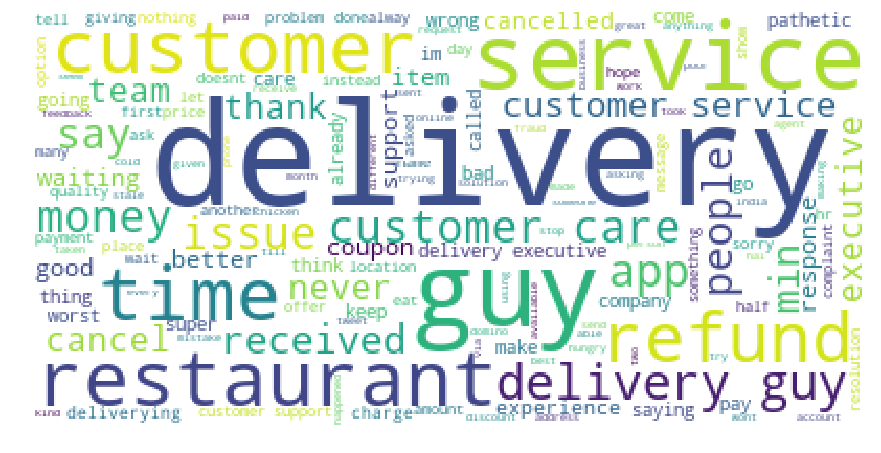

In [18]:
swiggy_word_tokens = word_tokenize(swiggy_corpus)
swiggy_corpus = ' '.join(swiggy_word_tokens)
cloud = WordCloud(background_color="white").generate(swiggy_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

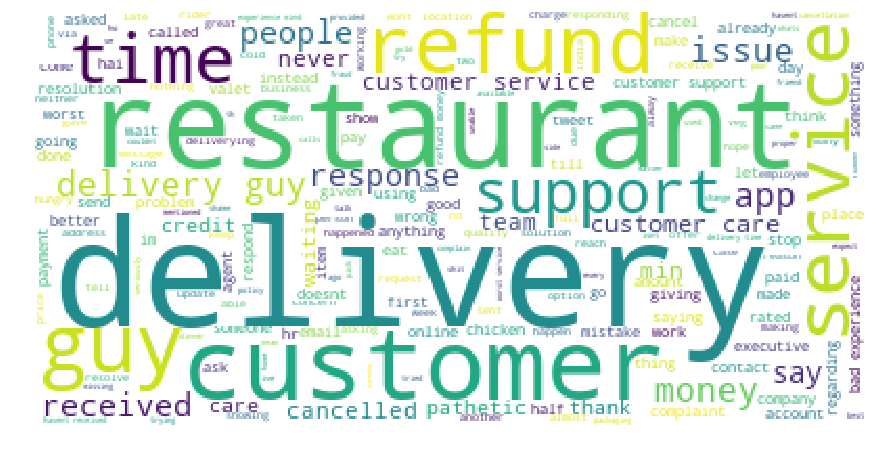

In [19]:
zomato_word_tokens = word_tokenize(zomato_corpus)
zomato_corpus = ' '.join(zomato_word_tokens)
cloud = WordCloud(background_color="white").generate(zomato_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

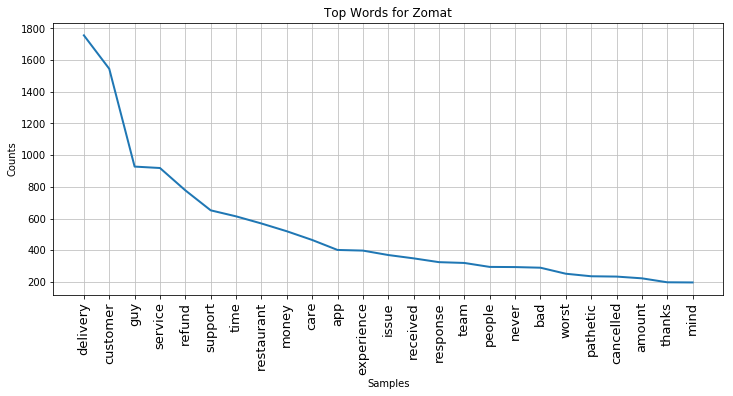

In [20]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(zomato_word_tokens)
fd.plot(25,cumulative=False, title='Top Words for Zomat')

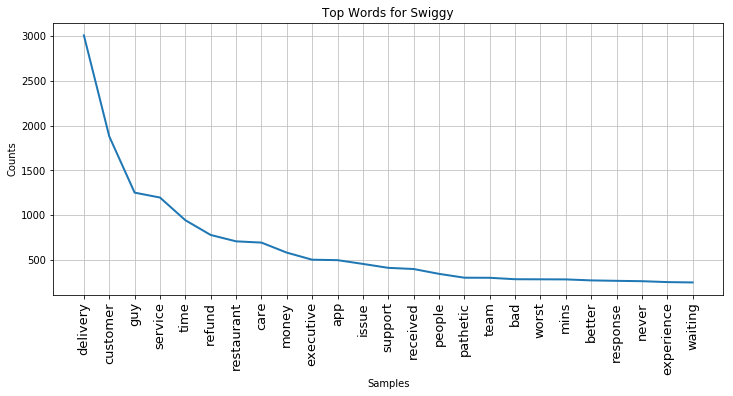

In [21]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(swiggy_word_tokens)
fd.plot(25,cumulative=False, title='Top Words for Swiggy')